# Dataset

In [31]:
import pandas as pd
import requests

def load_default_data():
    url = "https://raw.githubusercontent.com/vousmeevoyez/public-files/refs/heads/main/tabel_sensor4_generated.csv"
    response = requests.get(url)
    response.raise_for_status()
    from io import StringIO
    return pd.read_csv(StringIO(response.text))


In [32]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

global df
df = load_default_data()

# Buat fitur rata-rata kelembaban dari 4 sensor (untuk analisis entropy/CV), TANPA dipakai sebagai input ANN
if all(col in df.columns for col in ["kelembaban1", "kelembaban2", "kelembaban3", "kelembaban4"]):
    df["kelembaban_mean"] = df[["kelembaban1", "kelembaban2", "kelembaban3", "kelembaban4"]].mean(axis=1)
else:
    df["kelembaban_mean"] = df.get("kelembaban_tanah_persen", None)

# Kompatibilitas jika file lama masih punya kolom kelembaban_tanah_persen
if "kelembaban_tanah_persen" not in df.columns and "kelembaban_mean" in df.columns:
    df["kelembaban_tanah_persen"] = df["kelembaban_mean"]


# Inject fault to data

In [ ]:
import numpy as np
import functools

base = 'kelembaban_tanah_persen'


# --- Fault simulators (subtler, different seed per call) ---
def simulate_drift_fault(x, intensity=0.02, seed=None):
    rng=np.random.default_rng(seed)
    # Standar: i(t) = i(t-1) + α (akumulatif)
    # Implementasi: np.cumsum([α] * len(x)) atau np.arange(len(x)) * α
    # α adalah increment konstan per timestep
    alpha = intensity  # Increment konstan per timestep
    # i(0)=0, i(1)=α, i(2)=2α, ..., i(t)=t*α
    drift = np.arange(len(x)) * alpha  # Akumulatif mulai dari 0
    y=x+drift; m=np.abs(drift)>1e-6; return y,m

def simulate_spike_fault(x, intensity=0.08, p=0.015, seed=None):
    rng=np.random.default_rng(seed)
    # Standar: Intermittent dengan periode konstan τ
    # Menggunakan periodik (t % τ == 0) bukan random
    # p digunakan untuk menentukan periode: τ = 1/p (dibulatkan)
    tau = max(1, int(1.0 / p)) if p > 0 else len(x)
    spikes = (np.arange(len(x)) % tau == 0).astype(float) * (intensity * np.nanstd(x))
    y=x+spikes; m=spikes!=0; return y,m

def simulate_bias_fault(x, bias=0.08, seed=None):
    y=x+bias; m=np.ones(len(x),bool); return y,m

def simulate_hardware_fault(x, stuck_prob=0.08, loss_prob=0.05, seed=None):
    rng=np.random.default_rng(seed)
    n = len(x)
    # Pre-allocate random values
    rand_vals = rng.random(n)
    idx=rng.integers(n, size=n)
    m1 = rand_vals < stuck_prob
    # Use numpy advanced indexing for better performance
    y = x.copy()
    y[m1] = x[idx[m1]]
    m2 = rand_vals < loss_prob
    y[m2] = np.nan
    return y, (m1 | m2)

def simulate_multiple_faults(x, faults, seed=None):
    y=x.copy(); m=np.zeros(len(x),bool)
    for f,kw in faults:
        y,mi=f(y,**kw,seed=seed); m|=mi
    return y,m



In [34]:
def plot_with_mask(y_fault, mask, title, df=df, base=base, w=None, i0=0):
    if w is None: w = len(df)
    i1 = min(len(df), len(y_fault), len(mask), i0 + w)
    x = np.arange(i0, i1)
    plt.figure(figsize=(12,4))
    plt.plot(x, df[base].values[i0:i1], label="Original")
    plt.plot(x, y_fault[i0:i1], label=title, linestyle="--")
    idx = np.where(mask[i0:i1])[0]
    if len(idx): plt.scatter(x[idx], y_fault[i0:i1][idx], s=18, marker='o', label="fault points")
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def describe(name, y, m, df=df, base=base, w=None):
    if w is None: w = len(y)
    ref = df[base].to_numpy()
    d = y - ref
    print(f"{name}: mask_pos={m.sum()} | in first {w}: {m[:w].sum()} | "
          f"delta_mean={np.nanmean(d):.4f} delta_std={np.nanstd(d):.4f} delta_max={np.nanmax(d):.4f}")

#@ **Skenario 1**

Chosen random fault type: bias
bias: mask_pos=60763 | in first 60763: 60763 | delta_mean=0.3500 delta_std=0.0000 delta_max=0.3500
overall label rate: 1.0


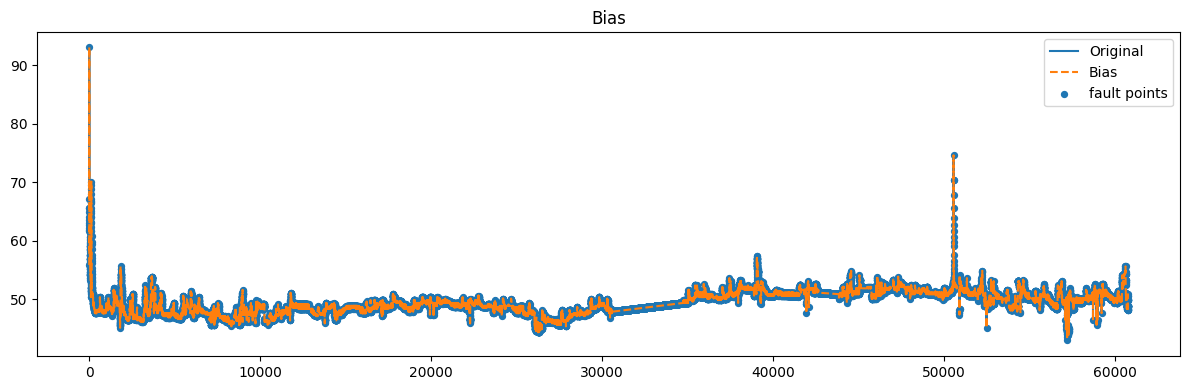

In [ ]:
import matplotlib.pyplot as plt



df_scenario_1 = df  # Avoid copy until we actually modify

# Candidate single-fault generators (return y, mask)
fault_choices = [
    ("drift",    simulate_drift_fault,    {"intensity": 0.15}),
    ("spike",    simulate_spike_fault,    {"intensity": 0.3, "p": 0.07}),
    ("bias",     simulate_bias_fault,     {"bias": 0.35}),
    ("hardware", simulate_hardware_fault, {"stuck_prob": 0.2, "loss_prob": 0.1}),
]

fault_name, fault_fn, fault_kwargs = fault_choices[np.random.randint(len(fault_choices))]
y_fault, m_fault = fault_fn(df[base].to_numpy(), **fault_kwargs)

if m_fault.sum() == 0:
    # fallback to a fault that guarantees positives
    y_fault, m_fault = simulate_spike_fault(
        df[base].to_numpy(), intensity=0.5, p=0.2, seed=123
    )

# Add fault column + label - now we need a copy since we're modifying
if df_scenario_1 is df:
    df_scenario_1 = df.copy()
col_fault = f"{base}_{fault_name}"
df_scenario_1[col_fault] = y_fault
df_scenario_1['label_fault'] = m_fault.astype(int)

# --- Guard 1: if no positives, inject stronger spikes
if df_scenario_1['label_fault'].sum() == 0:
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_1[base].to_numpy(), intensity=0.5, p=0.2, seed=456
    )
    df_scenario_1[base+'_spike_strong'] = y_spike_strong
    df_scenario_1['label_fault'] = (df_scenario_1['label_fault'].values | m_spike_strong).astype(int)

# --- Guard 2: if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_1['label_fault'].nunique() < 2:
    base_vals = df_scenario_1[base].to_numpy()
    deltas = []
    if col_fault in df_scenario_1:
        deltas.append(np.abs(df_scenario_1[col_fault].to_numpy() - base_vals))
    if base+'_spike_strong' in df_scenario_1:
        deltas.append(np.abs(df_scenario_1[base+'_spike_strong'].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_1['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_1['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_1)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_1['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_1.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_1.loc[idx, 'label_fault'] = 1

print(f"Chosen random fault type: {fault_name}")
describe(fault_name, y_fault, m_fault, df_scenario_1, base)
print("overall label rate:", df_scenario_1['label_fault'].mean())

# Plot in your preferred style
if fault_name == "hardware":
    plot_with_mask(np.nan_to_num(y_fault, nan=np.nanmedian(df[base])), m_fault, "Hardware (NaNs/stuck)")
else:
    plot_with_mask(y_fault, m_fault, fault_name.capitalize())

# Skenario 2

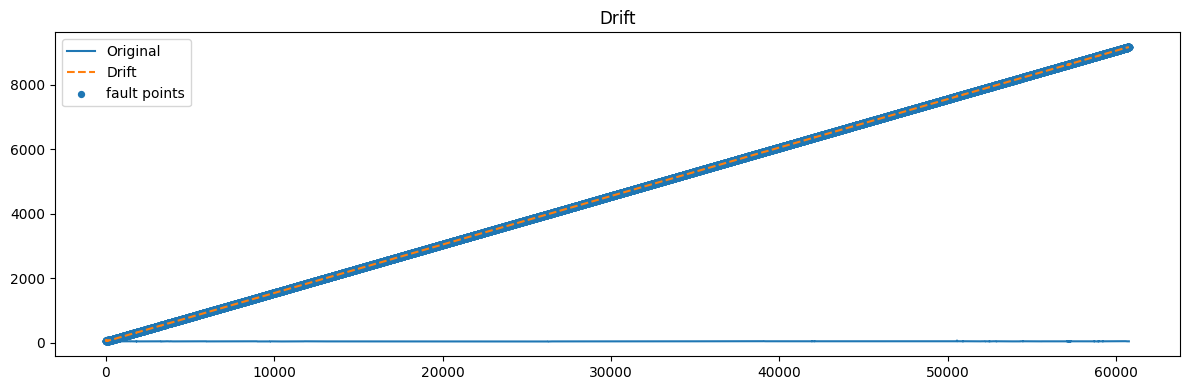

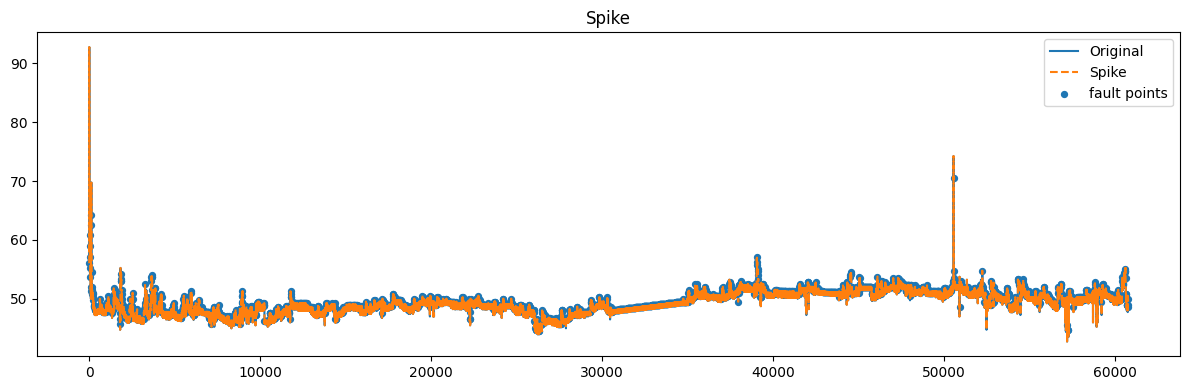

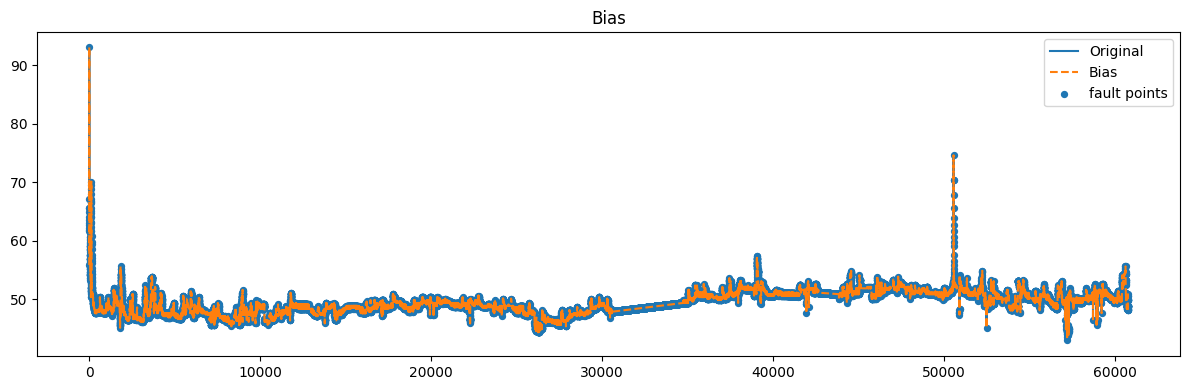

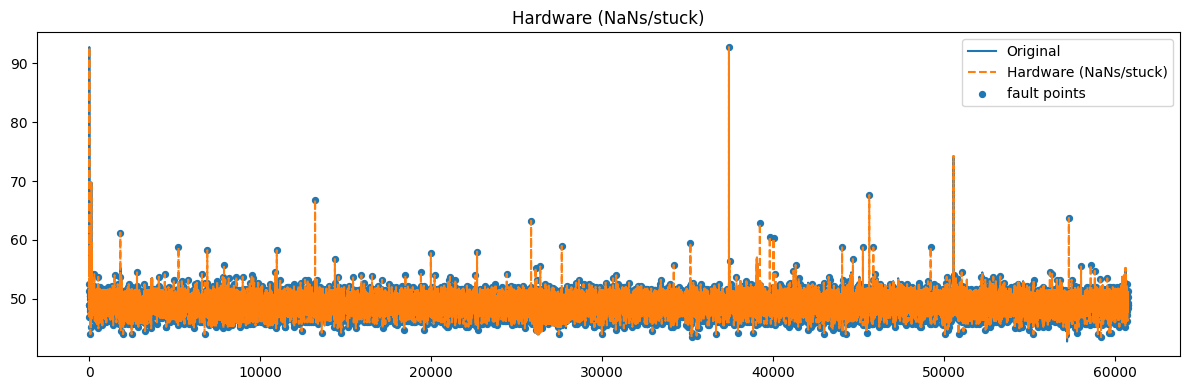

In [ ]:
# Skenario 2 (Hardened: avoid all-zero or all-one labels)

df_scenario_2 = df  # Delay copy

# Rebuild faults with masks
base_vals = df[base].to_numpy()  # Cache base values
y_drift, m_drift = simulate_drift_fault(base_vals, intensity=0.15)
y_spike, m_spike = simulate_spike_fault(base_vals, intensity=0.3, p=0.07)
y_bias,  m_bias  = simulate_bias_fault(base_vals, bias=0.35)   # note: returns all-True mask
y_hw,    m_hw    = simulate_hardware_fault(base_vals, stuck_prob=0.2, loss_prob=0.1)

# Now copy since we're modifying
if df_scenario_2 is df:
    df_scenario_2 = df.copy()
df_scenario_2[base+'_drift']    = y_drift
df_scenario_2[base+'_spike']    = y_spike
df_scenario_2[base+'_bias']     = y_bias
df_scenario_2[base+'_hardware'] = y_hw
df_scenario_2['label_fault']    = (m_drift | m_spike | m_bias | m_hw).astype(int)

# --- Guard 1: if no positives, inject stronger spikes
if df_scenario_2['label_fault'].sum() == 0:
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_2[base].to_numpy(), intensity=0.5, p=0.2, seed=456
    )
    df_scenario_2[base+'_spike_strong'] = y_spike_strong
    df_scenario_2['label_fault'] = (df_scenario_2['label_fault'].values | m_spike_strong).astype(int)

# --- Guard 2: if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_2['label_fault'].nunique() < 2:
    base_vals = df_scenario_2[base].to_numpy()
    deltas = []
    for c in [base+'_drift', base+'_spike', base+'_bias', base+'_hardware']:
        if c in df_scenario_2:
            deltas.append(np.abs(df_scenario_2[c].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_2['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_2['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_2)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_2['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_2.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_2.loc[idx, 'label_fault'] = 1

# Plots
plot_with_mask(y_drift, m_drift, "Drift")
plot_with_mask(y_spike, m_spike, "Spike")
plot_with_mask(y_bias,  m_bias,  "Bias")
plot_with_mask(np.nan_to_num(y_hw, nan=np.nanmedian(df[base])), m_hw, "Hardware (NaNs/stuck)")


# Skenario 3

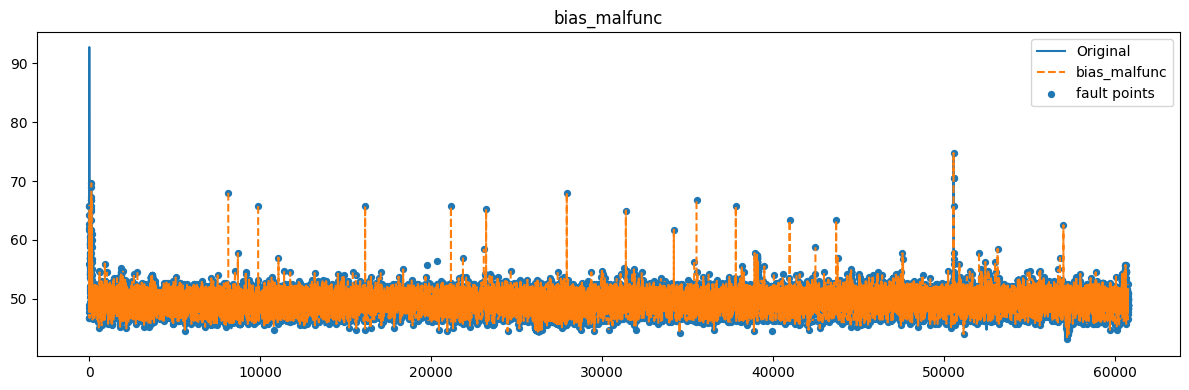

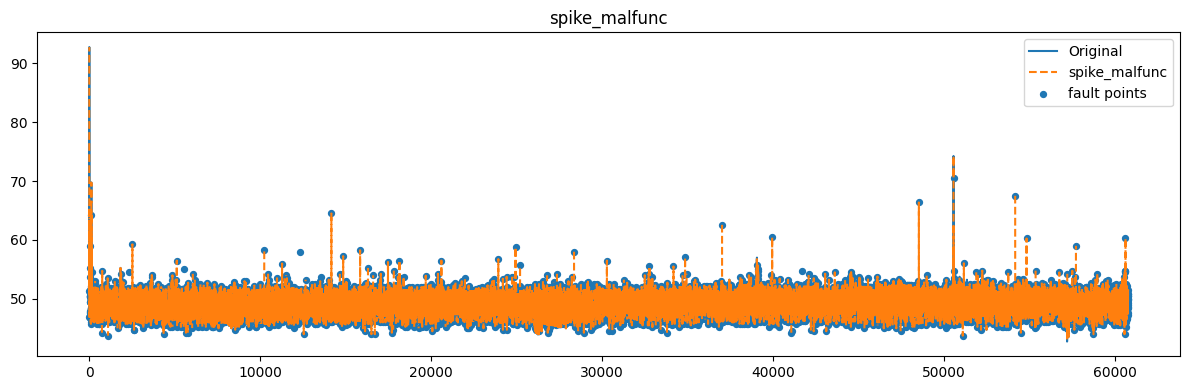

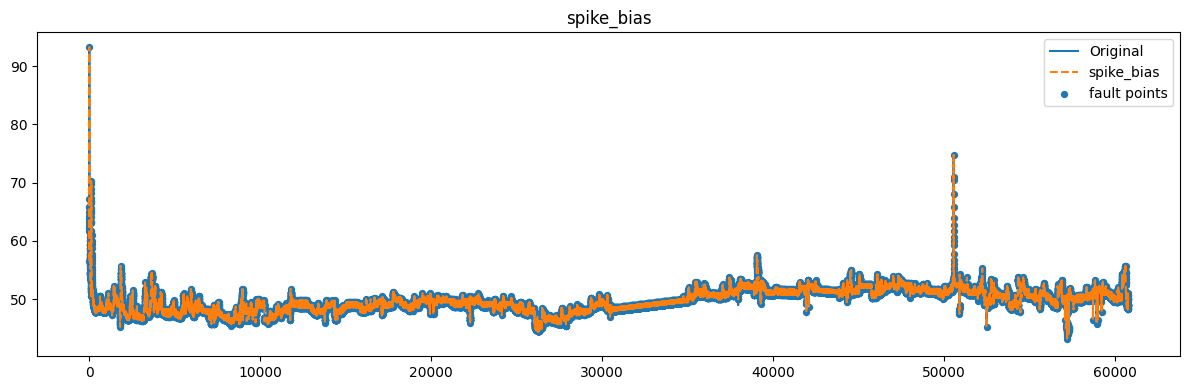

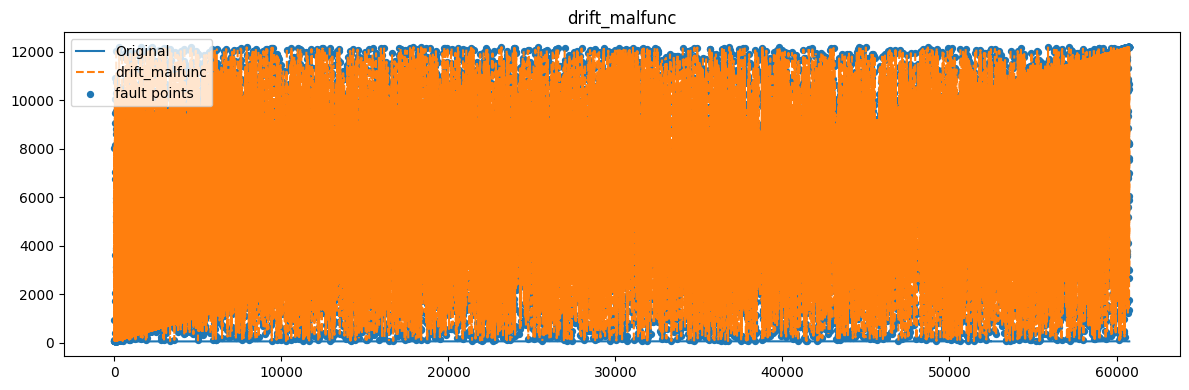

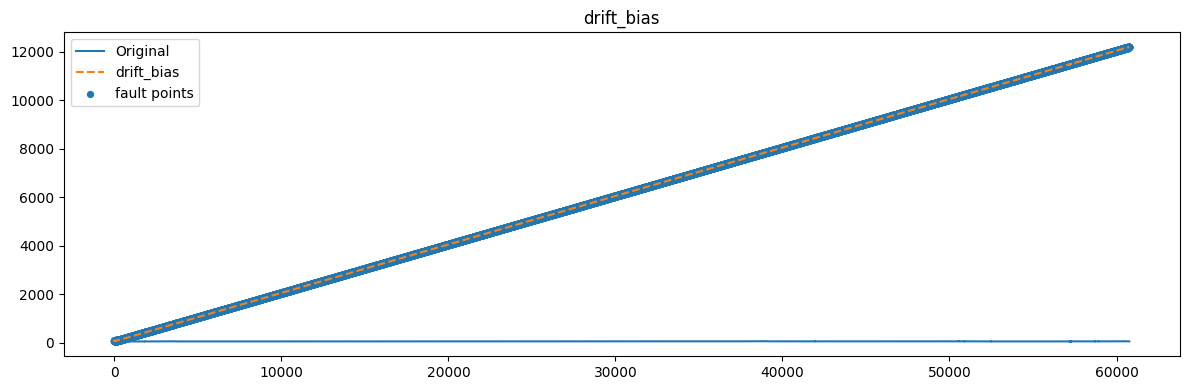

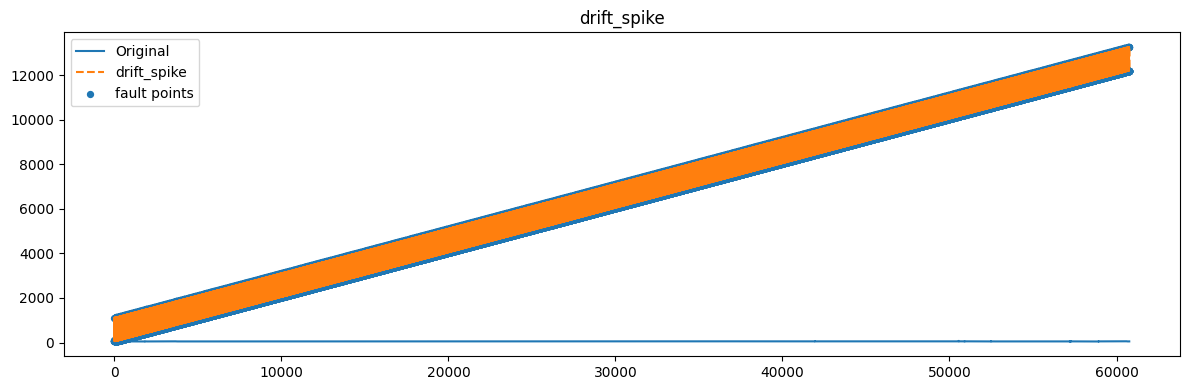

In [ ]:
# Skenario 3 (Hardened: never all-zero masks)

df_scenario_3 = df  # Delay copy
base_vals_sc3 = df[base].to_numpy()  # Cache base values

# Now copy since we're modifying
if df_scenario_3 is df:
    df_scenario_3 = df.copy()

# 1) Bias + Malfunc
y_bias_mal,  m_bias_mal  = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_bias_fault, {"bias": 0.5}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_bias_malfunc']  = y_bias_mal
df_scenario_3['label_bias_malfunc']  = m_bias_mal.astype(int)

# 2) Spike + Malfunc
y_spike_mal, m_spike_mal = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_spike_malfunc'] = y_spike_mal
df_scenario_3['label_spike_malfunc'] = m_spike_mal.astype(int)

# 3) Spike + Bias
y_spike_bias, m_spike_bias = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
     (simulate_bias_fault,  {"bias": 0.5})]
)
df_scenario_3[base+'_spike_bias']    = y_spike_bias
df_scenario_3['label_spike_bias']    = m_spike_bias.astype(int)

# 4) Drift + Malfunc
y_drift_mal, m_drift_mal = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2})]
)
df_scenario_3[base+'_drift_malfunc'] = y_drift_mal
df_scenario_3['label_drift_malfunc'] = m_drift_mal.astype(int)

# 5) Drift + Bias
y_drift_bias, m_drift_bias = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_bias_fault,  {"bias": 0.5})]
)
df_scenario_3[base+'_drift_bias']    = y_drift_bias
df_scenario_3['label_drift_bias']    = m_drift_bias.astype(int)

# 6) Drift + Spike
y_drift_spike, m_drift_spike = simulate_multiple_faults(
    base_vals_sc3,
    [(simulate_drift_fault, {"intensity": 0.2}),
     (simulate_spike_fault, {"intensity": 0.3, "p": 0.07})]
)
df_scenario_3[base+'_drift_spike']   = y_drift_spike
df_scenario_3['label_drift_spike']   = m_drift_spike.astype(int)

# Unified ground truth for Scenario 3
df_scenario_3['label_fault'] = np.logical_or.reduce(
    [m_bias_mal, m_spike_mal, m_spike_bias, m_drift_mal, m_drift_bias, m_drift_spike]
).astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_3['label_fault'].sum() == 0:
    # Inject a stronger sparse spike pattern and OR it in
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_3[base].to_numpy(), intensity=0.5, p=0.2, seed=456
    )
    df_scenario_3[base+'_spike_strong'] = y_spike_strong
    df_scenario_3['label_fault'] = (df_scenario_3['label_fault'].values | m_spike_strong).astype(int)

# --- Guard 2: if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_3['label_fault'].nunique() < 2:
    base_vals = df_scenario_3[base].to_numpy()
    deltas = []
    for c in [base+'_bias_malfunc', base+'_spike_malfunc', base+'_spike_bias', 
              base+'_drift_malfunc', base+'_drift_bias', base+'_drift_spike']:
        if c in df_scenario_3:
            deltas.append(np.abs(df_scenario_3[c].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_3['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_3['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_3)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_3['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_3.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_3.loc[idx, 'label_fault'] = 1

# (optional) quick sanity print
#print("Scenario 3 positive rate:", df_scenario_3['label_fault'].mean())

# Plots
plot_with_mask(y_bias_mal, m_bias_mal, "bias_malfunc")
plot_with_mask(y_spike_mal, m_spike_mal, "spike_malfunc")
plot_with_mask(y_spike_bias, m_spike_bias, "spike_bias")
plot_with_mask(y_drift_mal, m_drift_mal, "drift_malfunc")
plot_with_mask(y_drift_bias, m_drift_bias, "drift_bias")
plot_with_mask(y_drift_spike, m_drift_spike, "drift_spike")


# Skenario 4

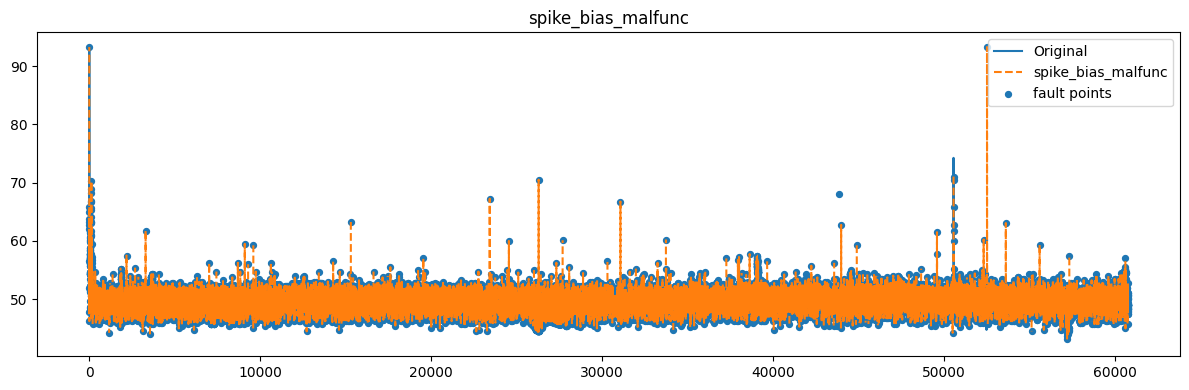

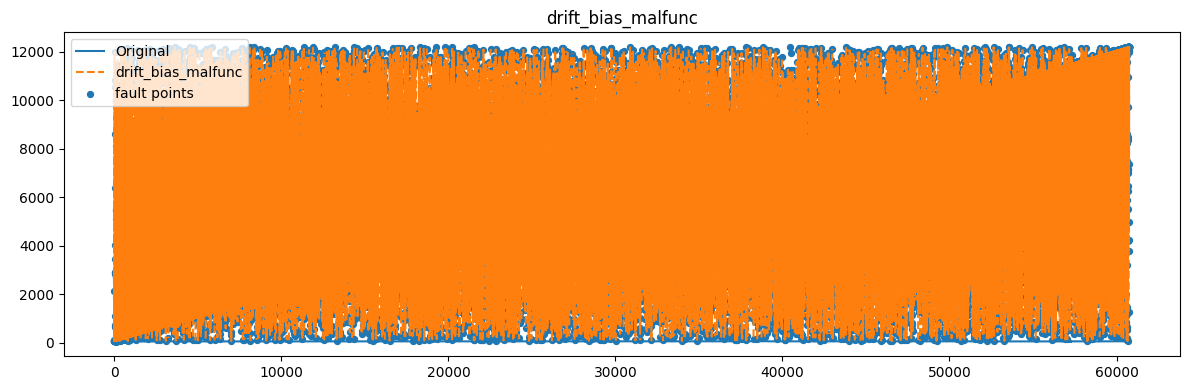

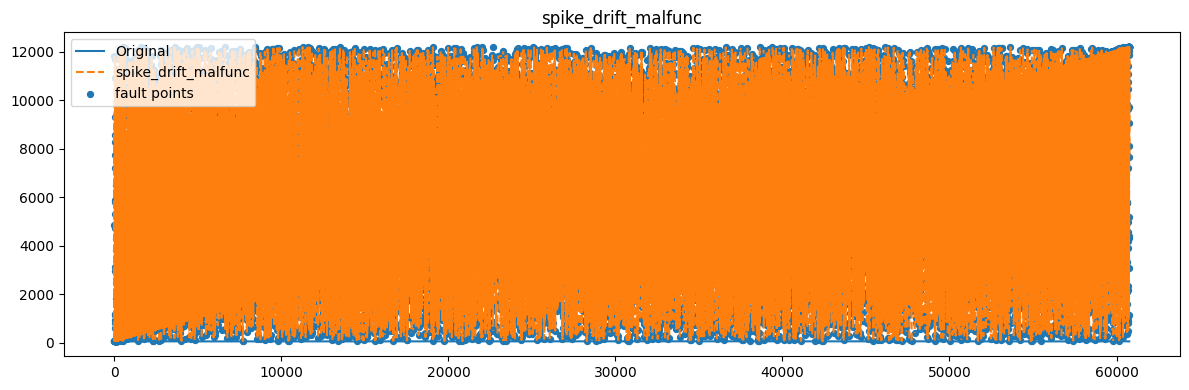

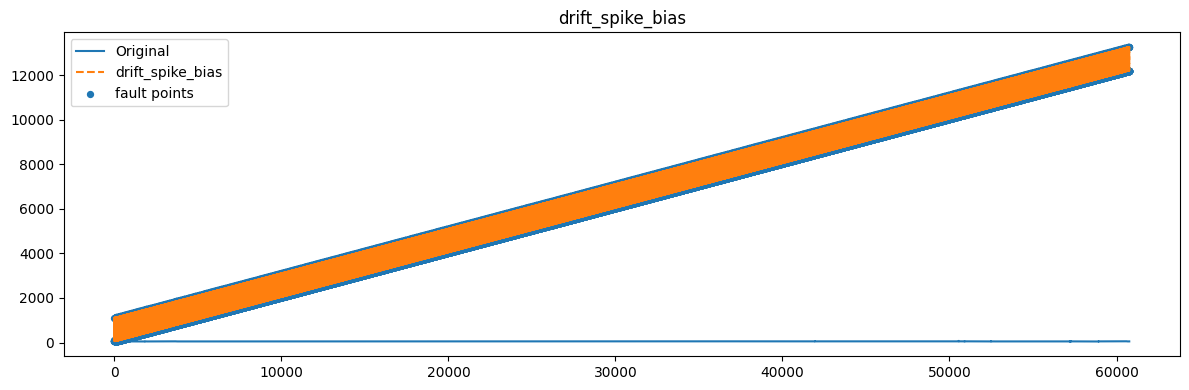

In [ ]:
# Skenario 4 (Hardened: never all-zero masks)

df_scenario_4 = df  # Delay copy
base_vals_sc4 = df[base].to_numpy()  # Cache base values

# Now copy since we're modifying
if df_scenario_4 is df:
    df_scenario_4 = df.copy()

# 1) Spike + Bias + Malfunc
y_spike_bias_mal, m_spike_bias_mal = simulate_multiple_faults(
    base_vals_sc4,
    [
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_bias_fault,  {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_spike_bias_malfunc'] = y_spike_bias_mal
df_scenario_4['label_spike_bias_malfunc'] = m_spike_bias_mal.astype(int)

# 2) Drift + Bias + Malfunc
y_drift_bias_mal, m_drift_bias_mal = simulate_multiple_faults(
    base_vals_sc4,
    [
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_bias_fault,  {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_drift_bias_malfunc'] = y_drift_bias_mal
df_scenario_4['label_drift_bias_malfunc'] = m_drift_bias_mal.astype(int)

# 3) Spike + Drift + Malfunc
y_spike_drift_mal, m_spike_drift_mal = simulate_multiple_faults(
    base_vals_sc4,
    [
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)
df_scenario_4[base+'_spike_drift_malfunc'] = y_spike_drift_mal
df_scenario_4['label_spike_drift_malfunc'] = m_spike_drift_mal.astype(int)

# 4) Drift + Spike + Bias
y_drift_spike_bias, m_drift_spike_bias = simulate_multiple_faults(
    base_vals_sc4,
    [
        (simulate_drift_fault, {"intensity": 0.2}),
        (simulate_spike_fault, {"intensity": 0.3, "p": 0.07}),
        (simulate_bias_fault,  {"bias": 0.5}),
    ]
)
df_scenario_4[base+'_drift_spike_bias'] = y_drift_spike_bias
df_scenario_4['label_drift_spike_bias'] = m_drift_spike_bias.astype(int)

# Unified label for Scenario 4
df_scenario_4['label_fault'] = np.logical_or.reduce(
    [m_spike_bias_mal, m_drift_bias_mal, m_spike_drift_mal, m_drift_spike_bias]
).astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_4['label_fault'].sum() == 0:
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_4[base].to_numpy(), intensity=0.5, p=0.2, seed=789
    )
    df_scenario_4[base+'_spike_strong'] = y_spike_strong
    df_scenario_4['label_fault'] = (df_scenario_4['label_fault'].values | m_spike_strong).astype(int)

# --- Guard 2: if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_4['label_fault'].nunique() < 2:
    base_vals = df_scenario_4[base].to_numpy()
    deltas = []
    for c in [base+'_spike_bias_malfunc', base+'_drift_bias_malfunc', 
              base+'_spike_drift_malfunc', base+'_drift_spike_bias']:
        if c in df_scenario_4:
            deltas.append(np.abs(df_scenario_4[c].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_4['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_4['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_4)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_4['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_4.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_4.loc[idx, 'label_fault'] = 1

# Plots
plot_with_mask(y_spike_bias_mal, m_spike_bias_mal, "spike_bias_malfunc")
plot_with_mask(y_drift_bias_mal, m_drift_bias_mal, "drift_bias_malfunc")
plot_with_mask(y_spike_drift_mal, m_spike_drift_mal, "spike_drift_malfunc")
plot_with_mask(y_drift_spike_bias, m_drift_spike_bias, "drift_spike_bias")


# Skenario 5

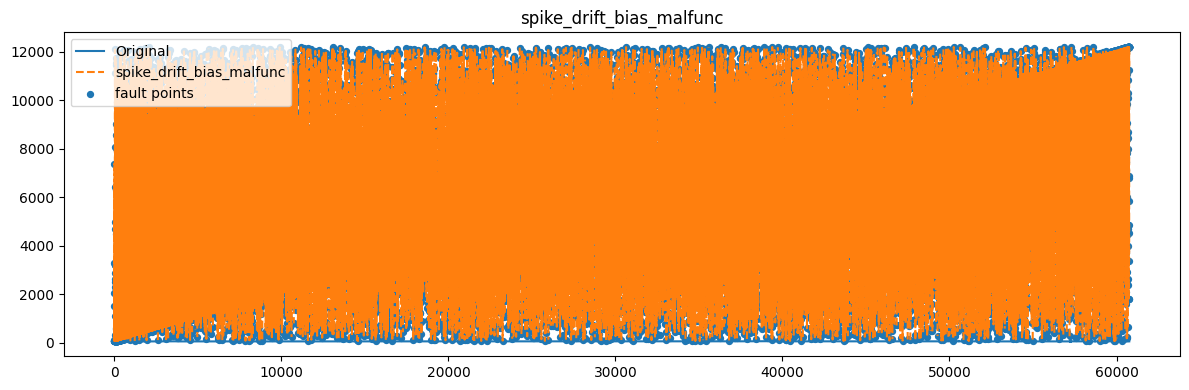

In [ ]:
# Skenario 5 (Hardened: never all-zero masks)

df_scenario_5 = df  # Delay copy
base_vals_sc5 = df[base].to_numpy()  # Cache base values

# Compose multiple faults
y_all, m_all = simulate_multiple_faults(
    base_vals_sc5,
    [
        (simulate_spike_fault,    {"intensity": 0.3, "p": 0.07}),
        (simulate_drift_fault,    {"intensity": 0.2}),
        (simulate_bias_fault,     {"bias": 0.5}),
        (simulate_hardware_fault, {"stuck_prob": 0.3, "loss_prob": 0.2}),
    ]
)

# Now copy since we're modifying
if df_scenario_5 is df:
    df_scenario_5 = df.copy()

col_name = base + '_spike_drift_bias_malfunc'
df_scenario_5[col_name] = y_all
df_scenario_5['label_fault'] = m_all.astype(int)

# --- Hardened guard: ensure at least some positives
if df_scenario_5['label_fault'].sum() == 0:
    # Inject a stronger spike pattern and OR it in
    y_spike_strong, m_spike_strong = simulate_spike_fault(
        df_scenario_5[base].to_numpy(), intensity=0.5, p=0.2, seed=1357
    )
    df_scenario_5[base+'_spike_strong'] = y_spike_strong
    df_scenario_5['label_fault'] = (df_scenario_5['label_fault'].values | m_spike_strong).astype(int)

    # If (extremely unlikely) still zero, flip a tiny random slice to positives
    if df_scenario_5['label_fault'].sum() == 0:
        rng = np.random.default_rng(2468)
        k = max(1, len(df_scenario_5)//200)  # ~0.5% of points
        idx = rng.choice(len(df_scenario_5), size=k, replace=False)
        lab = df_scenario_5['label_fault'].to_numpy()
        lab[idx] = 1
        df_scenario_5['label_fault'] = lab

# --- Guard 2: if still single-class (all-zeros or all-ones), rebuild from deviation
if df_scenario_5['label_fault'].nunique() < 2:
    base_vals = df_scenario_5[base].to_numpy()
    deltas = []
    col_name = base + '_spike_drift_bias_malfunc'
    if col_name in df_scenario_5:
        deltas.append(np.abs(df_scenario_5[col_name].to_numpy() - base_vals))
    if base+'_spike_strong' in df_scenario_5:
        deltas.append(np.abs(df_scenario_5[base+'_spike_strong'].to_numpy() - base_vals))
    if deltas:
        D = np.nanmax(np.stack(deltas, axis=1), axis=1)
        thr = np.nanpercentile(D, 80)  # top-20% by deviation -> positives
        df_scenario_5['label_fault'] = (D > thr).astype(int)

# --- Guard 3: last-resort tiny flips to ensure both classes
if df_scenario_5['label_fault'].nunique() < 2:
    rng = np.random.default_rng(4242)
    n = len(df_scenario_5)
    k = max(1, n // 200)  # ~0.5%
    if int(df_scenario_5['label_fault'].iloc[0]) == 1:
        idx = rng.choice(n, size=k, replace=False); df_scenario_5.loc[idx, 'label_fault'] = 0
    else:
        idx = rng.choice(n, size=k, replace=False); df_scenario_5.loc[idx, 'label_fault'] = 1

# Plot
plot_with_mask(y_all, m_all, "spike_drift_bias_malfunc")


# Fault detection
*   Neural network 1 & 2 Layer



In [ ]:
from functools import partial
import time, psutil
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import least_squares

def sigmoid(z): 
    # Numerically stable sigmoid
    z = np.asarray(z)
    pos_mask = z >= 0
    result = np.empty_like(z, dtype=float)
    result[pos_mask] = 1.0 / (1.0 + np.exp(-z[pos_mask]))
    result[~pos_mask] = np.exp(z[~pos_mask]) / (1.0 + np.exp(z[~pos_mask]))
    return result

def neural_net_predict(params, X, d, h1, h2, two_layers):
    i=0
    W1=params[i:i+d*h1].reshape(d,h1); i+=d*h1
    b1=params[i:i+h1].reshape(1,h1); i+=h1
    if two_layers:
        W2=params[i:i+h1*h2].reshape(h1,h2); i+=h1*h2
        b2=params[i:i+h2].reshape(1,h2); i+=h2
        W3=params[i:i+h2].reshape(h2,1); i+=h2
        a1=np.tanh(X@W1+b1); a2=np.tanh(a1@W2+b2)
    else:
        W3=params[i:i+h1].reshape(h1,1); i+=h1
        a2=np.tanh(X@W1+b1)
    b3=np.array([[params[i]]])
    return sigmoid(a2@W3+b3)

def residuals(params, X, y, d, h1, h2, two_layers):
    return (neural_net_predict(params, X, d, h1, h2, two_layers)-y).ravel()

def add_entropy_features_causal(df, base_col, *, entropy_fn, entropy_name, scales=None, weights=None,
                                window=None, step=16):
    s = df[base_col].astype(float)
    s_filled = s.ffill().bfill().to_numpy()
    if scales is None: scales = list(range(1,11))
    if window is None: window = max(256, 10*max(scales))
    n=len(s_filled); m=len(scales)
    feats = np.zeros((n, m), dtype=float)
    max_scale = max(scales) if scales else 1
    # Pre-compute indices for vectorization
    indices = np.arange(0, n, step)
    # Vectorized computation: compute entropy for all windows at once
    for i in indices:
        start = max(0, i - window + 1)
        end = min(i + step, n)
        x = s_filled[start:end]
        if len(x) >= max_scale:
            # Handle both regular functions and partial functions (where scales may be pre-bound)
            if isinstance(entropy_fn, partial) and 'scales' in entropy_fn.keywords:
                # scales is already bound in the partial function, don't pass it again
                vals = entropy_fn(x)
            else:
                # Regular function or partial without scales bound, pass scales as keyword
                vals = entropy_fn(x, scales=scales)
            vals_arr = np.asarray(vals, float)
            if len(vals_arr) == m:
                # Broadcast to all rows in this step
                feats[i:end] = vals_arr
    if weights:
        wvec = np.array([weights.get(sc, 1.0) for sc in scales], float)
        feats *= wvec.reshape(1,-1)
    cols = [f"{base_col}_{entropy_name}_s{s}" for s in scales]
    return pd.concat([df, pd.DataFrame(feats, columns=cols, index=df.index)], axis=1), cols

def make_features(df, base_cols, label_col='label_fault'):
    # Avoid unnecessary copy - work with views where possible
    if isinstance(base_cols,str): base_cols=[base_cols]
    feats=list(base_cols)
    for c in feats:
        if c not in df.columns:
            raise ValueError(f"Input column '{c}' not found in dataframe.")
    # handle missing values - use numpy operations for speed
    x = df.copy()  # Only copy when we need to modify
    new_feats = []
    for c in feats:
        if x[c].isna().any():
            isna_col = x[c].isna()
            x[c+"_isna"] = isna_col.astype(int)
            x[c] = x[c].fillna(x[c].median())
            new_feats.append(c+"_isna")
    feats.extend(new_feats)
    # Use numpy for faster mask computation
    feat_array = x[feats].values
    mask = (~np.isnan(feat_array).any(axis=1)) & x[label_col].notna().values
    return feat_array[mask], x.loc[mask, label_col].astype(int).values.reshape(-1,1), feats, mask

def time_block_split(X,y,tr_frac=0.6,va_frac=0.2):
    n=len(X); i1=int(n*tr_frac); i2=int(n*(tr_frac+va_frac))
    return X[:i1],X[i1:i2],X[i2:],y[:i1],y[i1:i2],y[i2:]

def neural_network_detection(
    faulty_df,
    original_cols=None,
    *,
    target_col='label_fault',
    base_signal=None,
    use_two_layers=True,
    h1_size=6,
    h2_size=3,
    max_nfev=60,


    # entropy plug-in
    entropy_fn=None,
    entropy_name=None,
    entropy_feature_weights=None,
    scales=None,
    entropy_window=None,
    entropy_step=16,
    use_lm=True,
    hide_logging=False
):
    # Set default base_signal if None (before any modifications)
    df_copied = False
    if base_signal is None:
        # Try common base signal names
        for candidate in ['kelembaban_tanah_persen', 'kelembaban_mean']:
            if candidate in faulty_df.columns:
                base_signal = candidate
                break
        # If still None, try to use mean of original_cols if available
        if base_signal is None:
            if original_cols and len(original_cols) > 0:
                available_cols = [c for c in original_cols if c in faulty_df.columns]
                if available_cols:
                    if len(available_cols) > 1:
                        # Need to copy before modifying
                        df = faulty_df.copy()
                        df_copied = True
                        df['kelembaban_mean'] = df[available_cols].mean(axis=1)
                        base_signal = 'kelembaban_mean'
                    else:
                        base_signal = available_cols[0]
                else:
                    # Last resort: use first numeric column
                    numeric_cols = faulty_df.select_dtypes(include=[np.number]).columns
                    if len(numeric_cols) > 0:
                        base_signal = numeric_cols[0]
            else:
                # Use first numeric column as fallback
                numeric_cols = faulty_df.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 0:
                    base_signal = numeric_cols[0]

    # Validate base_signal exists in dataframe
    if base_signal is None or base_signal not in faulty_df.columns:
        raise ValueError(f"base_signal '{base_signal}' not found in dataframe. Available columns: {list(faulty_df.columns)}")

    # Validate target_col is not None and exists in dataframe
    if target_col is None:
        raise ValueError("target_col cannot be None. Please provide a valid label column name (e.g., 'label_fault' or 'label_auto').")
    
    if target_col not in faulty_df.columns:
        raise ValueError(f"'{target_col}' not found.")
    
    # Now make a copy since we'll modify the dataframe (only if we haven't already copied)
    if not df_copied:
        df = faulty_df.copy()

    if df[target_col].nunique() < 2:
        inferred = np.zeros(len(df), dtype=bool)

        # try: infer from any faulted versions of the base signal (value-difference)
        # infer from any explicit mask columns
        inferred |= df.filter(regex=r"(?:^|_)fault$|label_", axis=1).apply(lambda s: s.fillna(0).astype(float)!=0).any(axis=1).to_numpy()

        # try: infer from any "faulted" signal versions of the input columns (value-difference)
        for b in (original_cols or []):
            if b in df.columns:
                base_vals = df[b].to_numpy()
                for c in df.columns:
                    if c.startswith(f"{b}_") and c != b:
                        xc = df[c].to_numpy()
                        mask = ~np.isnan(xc) & ~np.isnan(base_vals) & (xc != base_vals)
                        inferred |= mask

        if inferred.any() and inferred.sum() < len(inferred):
            df[target_col] = inferred.astype(int)
        else:
            # fallback: keep zeros columns
            deltas = []
            for c in df.columns:
                if c.startswith(f"{base_signal}_") and c != base_signal:
                    xc = df[c].to_numpy()
                    deltas.append(np.abs(xc - base_vals))
            if deltas:
                D = np.nanmax(np.stack(deltas, axis=1), axis=1)
                thr = np.nanpercentile(D, 80)
                df[target_col] = (D > thr).astype(int)
            else:
                # last fallback: quantile on base
                thr = df[base_signal].quantile(0.90)
                df[target_col] = (df[base_signal] > thr).astype(int)

    # final guard: if still single-class, force a tiny minority class
    if df[target_col].nunique() < 2:
        rng = np.random.default_rng(9918)
        n = len(df); k = max(1, n // 200)  # ~0.5%
        if int(df[target_col].iloc[0]) == 1:
            idx = rng.choice(n, size=k, replace=False); df.loc[idx, target_col] = 0
        else:
            idx = rng.choice(n, size=k, replace=False); df.loc[idx, target_col] = 1

    ent_cols=[]
    if entropy_fn is not None and entropy_name is not None:
        df, ent_cols = add_entropy_features_causal(
            df, base_signal,
            entropy_fn=entropy_fn, entropy_name=entropy_name,
            scales=scales, weights=entropy_feature_weights,
            window=entropy_window, step=entropy_step
        )

    X_all,y_all,used_features,mask = make_features(df, original_cols if original_cols is not None else ['kelembaban1','kelembaban2','kelembaban3','kelembaban4'], label_col=target_col)
    idx = df.index[mask]
    fault_classes = {'positive': idx[y_all.ravel()==1].tolist(),
                     'normal':   idx[y_all.ravel()==0].tolist()}

    X_tr,X_va,X_te,y_tr,y_va,y_te = time_block_split(X_all,y_all,tr_frac=0.6,va_frac=0.2)
    scaler=StandardScaler().fit(X_tr)
    X_tr=scaler.transform(X_tr); X_va=scaler.transform(X_va); X_te=scaler.transform(X_te)

    d = X_tr.shape[1]
    np.random.seed(42)
    param_size = d*h1_size + h1_size + (h1_size*h2_size + h2_size if use_two_layers else 0) + (h2_size if use_two_layers else h1_size) + 1
    p0=np.random.randn(param_size)

    if not use_lm: raise NotImplementedError("Only LM (use_lm=True) supported.")
    proc=psutil.Process(); t0=time.time(); u0,s0=proc.cpu_times()[:2]
    res=least_squares(residuals, p0, args=(X_tr, y_tr, d, h1_size, h2_size, use_two_layers), max_nfev=max_nfev, method='lm')
    trained=res.x
    dur=time.time()-t0; u1,s1=proc.cpu_times()[:2]
    cpu_pct=((u1+s1)-(u0+s0))/(dur*psutil.cpu_count())*100

    p_va=neural_net_predict(trained,X_va,d,h1_size,h2_size,use_two_layers).ravel()
    yv=y_va.ravel()
    # Vectorized threshold search for better performance
    ts=np.linspace(0.05,0.95,91)
    best_f1=-1; t_star=0.5
    # Pre-compute predictions for all thresholds at once
    p_va_expanded = p_va[:, None]  # Shape: (n_samples, 1)
    ts_expanded = ts[None, :]  # Shape: (1, n_thresholds)
    yhat_all = (p_va_expanded > ts_expanded).astype(int)  # Shape: (n_samples, n_thresholds)
    yv_expanded = yv[:, None]  # Shape: (n_samples, 1)
    # Vectorized computation of TP, FP, FN for all thresholds
    tp_all = ((yv_expanded == 1) & (yhat_all == 1)).sum(axis=0)
    fp_all = ((yv_expanded == 0) & (yhat_all == 1)).sum(axis=0)
    fn_all = ((yv_expanded == 1) & (yhat_all == 0)).sum(axis=0)
    # Vectorized precision, recall, F1
    prec_all = np.where(tp_all + fp_all > 0, tp_all / (tp_all + fp_all), 0.0)
    rec_all = np.where(tp_all + fn_all > 0, tp_all / (tp_all + fn_all), 0.0)
    f1_all = np.where(prec_all + rec_all > 0, 2 * prec_all * rec_all / (prec_all + rec_all), 0.0)
    best_idx = np.argmax(f1_all)
    best_f1 = f1_all[best_idx]
    t_star = ts[best_idx]

    p_te=neural_net_predict(trained,X_te,d,h1_size,h2_size,use_two_layers).ravel()
    results_df=pd.DataFrame({
        'split': ['val']*len(p_va)+['test']*len(p_te),
        'true_label': np.concatenate([y_va.ravel(), y_te.ravel()]),
        'predicted_prob': np.concatenate([p_va, p_te]),
    })
    results_df['predicted_label']=(results_df['predicted_prob']>t_star).astype(int)
    results_df['entropy']=-(results_df['predicted_prob']*np.log2(results_df['predicted_prob']+1e-8)
                            +(1-results_df['predicted_prob'])*np.log2(1-results_df['predicted_prob']+1e-8))
    results_df['uncertain']=results_df['entropy']>0.95
    results_df.attrs['t_star']=float(t_star)
    results_df.attrs['features']=used_features+ent_cols

    if not hide_logging:
        te_mask=(results_df['split']=='test').values
        yt=results_df.loc[te_mask,'true_label'].to_numpy()
        yh=results_df.loc[te_mask,'predicted_label'].to_numpy()
        acc=(yt==yh).mean()
        prec=precision_score(yt,yh,zero_division=0)
        rec=recall_score(yt,yh,zero_division=0)
        f1=f1_score(yt,yh,zero_division=0)
        print(f"Chosen threshold (val): {t_star:.2f}")
        print(f"[TEST] acc={acc:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f}")
        print(f"Train secs / CPU%: {dur:.2f} / {cpu_pct:.1f}")

    return fault_classes, results_df


In [41]:
import matplotlib.pyplot as plt

def visualize_fault_classes(fault_classes, two_bar_if_leq2=True):
    counts = {k: len(v) for k, v in fault_classes.items()}
    nonempty = {k: c for k, c in counts.items() if c > 0}

    plt.figure()

    if two_bar_if_leq2 and len(nonempty) <= 2:
        normal = counts.get('normal', 0)
        faulty = sum(c for k, c in counts.items() if k != 'normal')
        plt.bar(['faulty','normal'], [faulty, normal], color=['#FF6F61', '#6B5B95'])
    else:
        names = list(counts.keys())
        vals = [counts[k] for k in names]
        colors = plt.cm.tab20.colors[:len(names)]
        plt.bar(names, vals, color=colors)

    plt.ylabel('Sample Count')
    plt.xlabel('Fault Class')
    plt.title('Distribution of Fault Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# NN Grid search

In [ ]:
import os
os.environ.setdefault("OMP_NUM_THREADS","1")
os.environ.setdefault("MKL_NUM_THREADS","1")
os.environ.setdefault("OPENBLAS_NUM_THREADS","1")
os.environ.setdefault("NUMEXPR_NUM_THREADS","1")
import time, platform
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_curve
from math import isnan

# ===================== Config =====================
BASE_SIGNAL="kelembaban_tanah_persen"
POS_FRAC=0.20
USE_ENTROPY=False
ENTROPY_FN=None
ENTROPY_NAME="edmfuzzy"
ENTROPY_WEIGHTS=None
SCALES=list(range(1,11))

# Search grids
grid_h1=[3,5,8,12,16]
grid_h2=[0,4,8,12]  # keep 0 to represent "no second layer" in records

max_nfev=40
n_repeats=2
SEARCH_LAGS=2
FINAL_LAGS=5
early_margin=0.05
adaptive_first_repeat_floor=None

# Optimization: Adaptive max_nfev based on iteration
# Use fewer iterations for first repeat to speed up
MAX_NFEV_FIRST_REPEAT = max(20, max_nfev // 2)  # Faster first iteration
MAX_NFEV_SUBSEQUENT = max_nfev  # Full iterations for subsequent repeats

# ===================== Small helper =====================
def _coerce_int_series(s, default=0):
    return pd.to_numeric(s, errors="coerce").fillna(default).astype(int)

# ===================== System Introspection =====================
try:
    import psutil
    _PROC=psutil.Process(os.getpid())
    N_CPUS=psutil.cpu_count(logical=True) or 1
    TOTAL_RAM_MB=psutil.virtual_memory().total/1024/1024
    def _rss_mb_once(): return _PROC.memory_info().rss/1024/1024
    def _cpu_times_s():
        t=_PROC.cpu_times(); return float(getattr(t,"user",0.0)+getattr(t,"system",0.0))
except Exception:
    psutil=None
    import multiprocessing
    N_CPUS=multiprocessing.cpu_count()
    TOTAL_RAM_MB=np.nan
    def _rss_mb_once():
        if platform.system()=="Linux":
            try:
                with open(f"/proc/{os.getpid()}/status") as f:
                    for line in f:
                        if line.startswith("VmRSS:"):
                            return float(line.split()[1])/1024.0
            except: pass
        return float("nan")
    def _cpu_times_s(): return time.process_time()

# ===================== Prep & Metrics =====================
def _prepare_df_for_grid(df, base_signal=BASE_SIGNAL, pos_frac=POS_FRAC, n_lags=SEARCH_LAGS):
    label_col="label"
    if (label_col not in df.columns) or (df[label_col].nunique()<2):
        thr=df[base_signal].quantile(1-pos_frac); df=df.copy()
        df["label_auto"]=(df[base_signal]>=thr).astype(int)
        label_col="label_auto"
        print(f"[info] Using synthetic '{label_col}' | thr={thr:.4f} | pos_rate={df[label_col].mean():.3f}")
    dfe=df.copy(); s=dfe[base_signal]
    dfe[base_signal+"_diff"]=s.diff().fillna(0)
    for k in range(1,n_lags+1): dfe[f"{base_signal}_lag{k}"]=s.shift(k)
    num_cols=dfe.select_dtypes(include=[np.number]).columns.tolist()
    exclude={"label","label_auto",base_signal}
    original_cols=[c for c in num_cols if c not in exclude]
    dfe=dfe.fillna(0)
    return dfe, label_col, original_cols

def _summarize_best_f1_from_arrays(y_true,p,ent_arr=None):
    if len(np.unique(y_true))<2:
        ent=float(np.nan) if ent_arr is None else float(np.nanmean(ent_arr))
        return 0.0,0.0,0.0,0.5,0.0,ent
    precs,recs,thrs=precision_recall_curve(y_true,p)
    f1s=2*precs*recs/(precs+recs+1e-12)
    best_idx=int(np.nanargmax(f1s))
    best_f1=float(f1s[best_idx])
    best_t=float(thrs[best_idx]) if best_idx<len(thrs) else 0.5
    yhat=(p>best_t)
    acc=float((yhat==y_true).mean())
    prec=float(precs[best_idx]); rec=float(recs[best_idx])
    ent=float(np.nan) if ent_arr is None else float(np.nanmean(ent_arr))
    return acc,prec,rec,best_t,best_f1,ent

def _entropy_args():
    return dict(entropy_fn=ENTROPY_FN,entropy_name=ENTROPY_NAME,entropy_feature_weights=ENTROPY_WEIGHTS,scales=SCALES) if USE_ENTROPY and ENTROPY_FN else {}

def _bucket_dataset_length(N):
    if N<=5000: return 5000
    if N<=7000: return 7000
    if N<=10000: return 10000
    return ">10000"

# ===================== Global best tracking =====================
try:
    from multiprocessing import Manager
    _mgr=Manager()
    _global_best_f1=_mgr.Value('d',0.0)
except Exception:
    class _Dummy:
        def __init__(self): self.value=0.0
    _global_best_f1=_Dummy()

# ===================== Core Runner (records h1 & h2, single layer) - OPTIMIZED =====================
def _run_config_avg(h1,h2,dfe,original_cols,label_col,ea,base_signal,n_repeats):
    accs=[];precs=[];recs=[];f1s=[];ents=[];ts=[]
    for r in range(n_repeats):
        # Optimization: Use fewer iterations for first repeat to speed up
        current_max_nfev = MAX_NFEV_FIRST_REPEAT if r == 0 else MAX_NFEV_SUBSEQUENT

        # single-layer training; pass h2_size only for bookkeeping
        _,res=neural_network_detection(
            faulty_df=dfe, original_cols=original_cols,
            use_two_layers=False, h1_size=h1, h2_size=h2,
            max_nfev=current_max_nfev, use_lm=True, hide_logging=True,
            target_col=label_col, base_signal=base_signal, **ea
        )
        te=res[res['split']=='test']
        y_true=te["true_label"].to_numpy(dtype=np.int8)
        p=te["predicted_prob"].to_numpy(dtype=np.float32)
        ent_arr=te["entropy"].to_numpy(dtype=np.float32) if "entropy" in te.columns else None
        acc,prec,rec,best_t,best_f1,ent=_summarize_best_f1_from_arrays(y_true,p,ent_arr)
        accs.append(acc);precs.append(prec);recs.append(rec);f1s.append(best_f1);ents.append(ent);ts.append(best_t)

        # Enhanced early stopping: skip remaining repeats if first result is poor
        if r==0:
            if adaptive_first_repeat_floor is not None and best_f1<adaptive_first_repeat_floor:
                # If first repeat is below floor, fill remaining with same values for averaging
                for _ in range(n_repeats - len(accs)):
                    accs.append(acc); precs.append(prec); recs.append(rec); f1s.append(best_f1); ents.append(ent); ts.append(best_t)
                break
            # More aggressive early stopping: if significantly worse than best, skip remaining
            if (best_f1+early_margin*1.5)<float(_global_best_f1.value) and _global_best_f1.value > 0.1:
                # Fill remaining with current values
                for _ in range(n_repeats - len(accs)):
                    accs.append(acc); precs.append(prec); recs.append(rec); f1s.append(best_f1); ents.append(ent); ts.append(best_t)
                break

    avg_f1=float(np.nanmean(f1s))
    if avg_f1>_global_best_f1.value: _global_best_f1.value=avg_f1
    return dict(accuracy=float(np.nanmean(accs)),precision=float(np.nanmean(precs)),recall=float(np.nanmean(recs)),
                f1_best=avg_f1,best_t=float(np.nanmean(ts)),avg_entropy=float(np.nanmean(ents)))

# ===================== Grid Runner with checkpoint (h1,h2) =====================
def run_grid_with_checkpoint(df,scenario_name,checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",n_lags=SEARCH_LAGS):
    dfe,label_col,original_cols=_prepare_df_for_grid(df,n_lags=n_lags); ea=_entropy_args()
    keys=[(int(h1),int(h2)) for h1 in grid_h1 for h2 in grid_h2]

    done=set()
    if os.path.exists(checkpoint_path):
        try:
            prev=pd.read_csv(checkpoint_path)
            prev=prev[(prev["scenario"]==scenario_name)]
            if {"h1_size","h2_size"}.issubset(prev.columns):
                prev_h1=_coerce_int_series(prev["h1_size"], default=0)
                prev_h2=_coerce_int_series(prev["h2_size"], default=0)
                mask=pd.notna(prev_h1) & pd.notna(prev_h2)
                done={(int(h1),int(h2)) for h1,h2 in zip(prev_h1[mask], prev_h2[mask])}
            elif "h1_size" in prev.columns:
                done=set()
        except Exception:
            pass

    todo=[pair for pair in keys if pair not in done]
    if not todo:
        lb=pd.read_csv(checkpoint_path); lb=lb[lb["scenario"]==scenario_name].copy()
        if "h1_size" not in lb: lb["h1_size"]=np.nan
        if "h2_size" not in lb: lb["h2_size"]=0
        lb["h1_size"]=pd.to_numeric(lb["h1_size"], errors="coerce")
        lb["h2_size"]=pd.to_numeric(lb["h2_size"], errors="coerce").fillna(0)
        keep_cols=[c for c in lb.columns if c in {"scenario","h1_size","h2_size","accuracy","precision","recall","f1_best","best_t","avg_entropy","N","dataset_length","dataset_length_bucket","pos_rate","label_used","wall_time_s","cpu_time_s","cpu_percent","max_rss_mb","mem_percent"}]
        lb=lb[keep_cols]
        for c in ["accuracy","precision","recall","f1_best","avg_entropy","mem_percent"]:
            if c in lb: lb[c]=lb[c].round(4)
        if "best_t" in lb: lb["best_t"]=lb["best_t"].round(3)
        if "cpu_percent" in lb: lb["cpu_percent"]=lb["cpu_percent"].round(1)
        if "max_rss_mb" in lb: lb["max_rss_mb"]=lb["max_rss_mb"].round(1)
        return lb.sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False).reset_index(drop=True)

    try:
        from joblib import Parallel, delayed
        use_parallel=True
        if n_jobs is None:
            try:
                phys=psutil.cpu_count(logical=False) if psutil else None
                base=phys or N_CPUS//2 or N_CPUS
            except: base=N_CPUS
            # Optimization: Use more cores for parallel processing, but cap at reasonable limit
            n_jobs=min(max(2,base),min(12,N_CPUS))  # Use at least 2 cores, up to 12 or available
    except Exception:
        use_parallel=False; n_jobs=1

    t0_wall=time.perf_counter(); t0_cpu=_cpu_times_s()
    N=len(dfe); pos_rate=float(dfe[label_col].mean()); ds_bucket=_bucket_dataset_length(N)

    def run_one(h1,h2):
        stats=_run_config_avg(h1,h2,dfe,original_cols,label_col,ea,BASE_SIGNAL,n_repeats)
        return dict(scenario=scenario_name,h1_size=h1,h2_size=h2,N=N,dataset_length=N,
                    dataset_length_bucket=ds_bucket,pos_rate=pos_rate,label_used=label_col,**stats)

    if use_parallel:
        # Optimization: Use batch_size to reduce overhead, verbose for progress tracking
        results=Parallel(n_jobs=n_jobs,backend=("threading" if backend=="threading" else "loky"),
                         prefer=("threads" if backend=="threading" else "processes"),
                         batch_size=max(1, len(todo) // (n_jobs * 2)),  # Batch processing to reduce overhead
                         verbose=0)(  # Set to 1 for progress output if needed
            [delayed(run_one)(h1,h2) for (h1,h2) in todo]
        )
    else:
        results=[run_one(h1,h2) for (h1,h2) in todo]

    wall_dur=time.perf_counter()-t0_wall; cpu_dur=_cpu_times_s()-t0_cpu
    rss1=_rss_mb_once(); max_rss=rss1 if not isnan(rss1) else np.nan
    cpu_percent=(cpu_dur/wall_dur)/N_CPUS*100 if wall_dur>0 else 0.0
    mem_percent=(max_rss/TOTAL_RAM_MB*100) if TOTAL_RAM_MB and not isnan(max_rss) else np.nan

    df_new=pd.DataFrame(results)
    df_new["h1_size"]=_coerce_int_series(df_new["h1_size"], default=0)
    df_new["h2_size"]=_coerce_int_series(df_new["h2_size"], default=0)
    df_new["wall_time_s"]=round(wall_dur,3); df_new["cpu_time_s"]=round(cpu_dur,3)
    df_new["cpu_percent"]=round(cpu_percent,1); df_new["max_rss_mb"]=round(max_rss,1) if not isnan(max_rss) else np.nan
    df_new["mem_percent"]=round(mem_percent,4) if not isnan(mem_percent) else np.nan
    for c in ["accuracy","precision","recall","f1_best","avg_entropy","mem_percent"]:
        if c in df_new: df_new[c]=df_new[c].round(4)
    if "best_t" in df_new: df_new["best_t"]=df_new["best_t"].round(3)

    if os.path.exists(checkpoint_path):
        try:
            old=pd.read_csv(checkpoint_path)
            if "h2_size" not in old: old["h2_size"]=0
            all_rows=pd.concat([old,df_new],ignore_index=True)
        except Exception:
            all_rows=df_new
    else:
        all_rows=df_new

    if "h2_size" not in all_rows: all_rows["h2_size"]=0
    all_rows["h1_size"]=pd.to_numeric(all_rows["h1_size"], errors="coerce").fillna(0).astype(int)
    all_rows["h2_size"]=pd.to_numeric(all_rows["h2_size"], errors="coerce").fillna(0).astype(int)
    all_rows.to_csv(checkpoint_path,index=False)

    lb=(all_rows[all_rows["scenario"]==scenario_name].copy()
        .sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False)
        .reset_index(drop=True))
    return lb

# ===================== Helpers =====================
def _subsample_df(df, frac):
    if frac>=1.0: return df
    n=max(1000,int(len(df)*frac))
    return df.iloc[:n].copy()

# ===================== Two-stage (uses pairs, robust to NaNs) =====================
def run_grid_two_stage(df,scenario_name,checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",coarse_frac=0.25,coarse_repeats=1,top_k=3):
    global n_repeats
    dfe_small=_subsample_df(df,coarse_frac)
    n_repeats_orig=n_repeats
    n_repeats=coarse_repeats

    lb_stage1=run_grid_with_checkpoint(
        dfe_small, scenario_name+" [stage1]",
        checkpoint_path=checkpoint_path.replace(".csv","_stage1.csv"),
        n_jobs=n_jobs, backend=backend, n_lags=SEARCH_LAGS
    )

    stage1_top=(lb_stage1.sort_values("f1_best",ascending=False)
                .head(min(top_k,len(lb_stage1))).copy())

    if "h1_size" not in stage1_top: stage1_top["h1_size"]=np.nan
    if "h2_size" not in stage1_top: stage1_top["h2_size"]=0
    stage1_top["h1_size"]=pd.to_numeric(stage1_top["h1_size"], errors="coerce")
    if stage1_top["h1_size"].isna().all():
        stage1_top["h1_size"]=grid_h1[0]
    else:
        stage1_top["h1_size"]=stage1_top["h1_size"].ffill().bfill().fillna(grid_h1[0])
    stage1_top["h2_size"]=pd.to_numeric(stage1_top["h2_size"], errors="coerce").fillna(0)
    stage1_top["h1_size"]=stage1_top["h1_size"].astype(int)
    stage1_top["h2_size"]=stage1_top["h2_size"].astype(int)
    keep_pairs=list(stage1_top[["h1_size","h2_size"]].itertuples(index=False, name=None))

    original_grid_h1=list(grid_h1)
    original_grid_h2=list(grid_h2)
    try:
        if keep_pairs:
            kh1=sorted(set([h1 for (h1,_) in keep_pairs]))
            kh2=sorted(set([h2 for (_,h2) in keep_pairs]))
            globals()["grid_h1"]=kh1
            globals()["grid_h2"]=kh2
        n_repeats=n_repeats_orig
        lb_full=run_grid_with_checkpoint(
            df, scenario_name,
            checkpoint_path=checkpoint_path, n_jobs=n_jobs, backend=backend, n_lags=FINAL_LAGS
        )
    finally:
        globals()["grid_h1"]=original_grid_h1
        globals()["grid_h2"]=original_grid_h2
        n_repeats=n_repeats_orig
    return lb_full, lb_stage1

# ===================== Multi-scenario wrapper =====================
def run_all_scenarios(checkpoint_path="nn_grid_checkpoint.csv",n_jobs=None,backend="loky",two_stage=True,coarse_frac=0.25,coarse_repeats=1,top_k=3):
    scenarios=[]
    for i in range(1,6):
        var=f"df_scenario_{i}"
        if var in globals(): scenarios.append((f"Scenario {i}", globals()[var]))
    if not scenarios:
        print("[warn] No scenarios found."); return None,None
    all_lbs=[]; stage1_lbs=[]
    for name,df in scenarios:
        print(f"\n=== {name} ===")
        if two_stage:
            lb, lb1=run_grid_two_stage(df,name,checkpoint_path=checkpoint_path,n_jobs=n_jobs,backend=backend,coarse_frac=coarse_frac,coarse_repeats=coarse_repeats,top_k=top_k)
            stage1_lbs.append(lb1)
        else:
            lb=run_grid_with_checkpoint(df,name,checkpoint_path=checkpoint_path,n_jobs=n_jobs,backend=backend,n_lags=SEARCH_LAGS)
        all_lbs.append(lb)
        print("\nTop 5:"); print(lb.head(5).to_string(index=False))
        print("\nBest config:\n", lb.iloc[0].to_dict())
        safe_name=name.replace(' ','_').lower()
        lb.to_csv(f"nn_grid_leaderboard_{safe_name}.csv",index=False)

    combined=pd.concat(all_lbs,ignore_index=True)
    combined["scenario_rank"]=combined.groupby("scenario")["f1_best"].rank(ascending=False,method="dense")
    combined_sorted=combined.sort_values(by=["f1_best","accuracy","recall","precision"],ascending=False).reset_index(drop=True)
    print("\n=== Combined top 10 by best F1 ==="); print(combined_sorted.head(10).to_string(index=False))
    combined_sorted.to_csv("nn_grid_combined_leaderboard.csv",index=False)
    return combined_sorted, all_lbs

# ===================== Example usage =====================
# lb = run_grid_with_checkpoint(df_scenario_1, "Scenario 1", checkpoint_path="nn_grid_checkpoint.csv", n_jobs=None, backend="loky", n_lags=SEARCH_LAGS)
# lb_full, lb_stage1 = run_grid_two_stage(df_scenario_1, "Scenario 1", checkpoint_path="nn_grid_checkpoint.csv", n_jobs=None, backend="loky", coarse_frac=0.25, coarse_repeats=1, top_k=3)
combined_sorted, all_lbs = run_all_scenarios(checkpoint_path="nn_grid_checkpoint.csv", n_jobs=None, backend="loky", two_stage=True)



=== Scenario 1 ===
[info] Using synthetic 'label_auto' | thr=48.5000 | pos_rate=0.201


/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 1        3        0 60763           60763                >10000  0.209042 label_auto    0.8204     0.9969     1.0   0.9985   0.906       0.0607       143.76        0.64          0.2       616.5       4.7514
Scenario 1        3        4 60763           60763                >10000  0.209042 label_auto    0.8204     0.9969     1.0   0.9985   0.906       0.0607       143.76        0.64          0.2       616.5       4.7514
Scenario 1        3        8 60763           60763                >10000  0.209042 label_auto    0.8204     0.9969     1.0   0.9985   0.906       0.0607       143.76        0.64          0.2       616.5       4.7514

Best config:
 {'scenario': 'Scenario 1', 'h1_size': 3, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])
/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 2        8        0 60763           60763                >10000  0.209042 label_auto    0.9493     0.9286  0.9299   0.9292   0.026        0.052      942.282        3.54          0.2       616.7       4.7531
Scenario 2        8        4 60763           60763                >10000  0.209042 label_auto    0.9493     0.9286  0.9299   0.9292   0.026        0.052      942.282        3.54          0.2       616.7       4.7531
Scenario 2        8        8 60763           60763                >10000  0.209042 label_auto    0.9493     0.9286  0.9299   0.9292   0.026        0.052      942.282        3.54          0.2       616.7       4.7531

Best config:
 {'scenario': 'Scenario 2', 'h1_size': 8, 'h2_s

/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])
/tmp/ipython-input-3937387405.py:287: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stage1_top["h1_size"]=stage1_top["h1_size"].fillna(method="ffill").fillna(method="bfill").fillna(grid_h1[0])


[info] Using synthetic 'label_auto' | thr=50.7500 | pos_rate=0.209

Top 5:
  scenario  h1_size  h2_size     N  dataset_length dataset_length_bucket  pos_rate label_used  accuracy  precision  recall  f1_best  best_t  avg_entropy  wall_time_s  cpu_time_s  cpu_percent  max_rss_mb  mem_percent
Scenario 5        3        0 60763           60763                >10000  0.209042 label_auto    0.9312     0.9573  0.8457   0.8981   0.835       0.3444       35.104        0.26          0.4       620.3       4.7807
Scenario 5        3        4 60763           60763                >10000  0.209042 label_auto    0.9312     0.9573  0.8457   0.8981   0.835       0.3444       35.104        0.26          0.4       620.3       4.7807
Scenario 5        3        8 60763           60763                >10000  0.209042 label_auto    0.9312     0.9573  0.8457   0.8981   0.835       0.3444       35.104        0.26          0.4       620.3       4.7807

Best config:
 {'scenario': 'Scenario 5', 'h1_size': 3, 'h2_s

## Variation Coefficient Analysis

In [ ]:
import numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# 0) CONFIG (DF-ONLY)
# =========================
SENSOR_COLS = ["kelembaban1","kelembaban2","kelembaban3","kelembaban4"]
RANDOM_SEED = 42
JSD_BINS = 50
METHOD_ORDER = ["MSE","CMSE","FME","EDM-Fuzzy","JSD-Fuzzy"]
DISPLAY_MAX_ROWS=200000
DISPLAY_MAX_COLS=2000
TEST_LENGTHS_DEFAULT = [512, 1024, 2048, 4096, 8192]
SCALES_BASE = [4, 8, 16, 32, 64, 128]

# =========================
# 1) USE EXISTING DATAFRAME
# =========================
if "df" not in globals():
    raise RuntimeError("DataFrame df belum ada. Jalankan cell pembentukan df terlebih dahulu.")
# Only copy if we're going to modify it - check if we actually need to modify
# df = df.copy()  # Removed unnecessary copy

missing = [c for c in SENSOR_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Kolom sensor tidak ditemukan: {missing}. Kolom tersedia: {list(df.columns)}")

# =========================
# 2) UTILS
# =========================
def _as_1d(x):
    x = np.asarray(x, dtype=float)
    return x.reshape(-1)

def _nan_safe(x):
    x = np.asarray(x, dtype=float)
    if np.isnan(x).any():
        m = np.nanmean(x)
        x = np.where(np.isnan(x), m, x)
    return x

def segment_signal(x: np.ndarray, scale: int) -> np.ndarray:
    x = _as_1d(x)
    n = (len(x)//scale)*scale
    if n <= 0: return np.array([])
    return x[:n].reshape(-1, scale)

def entropy_from_probs(p: np.ndarray, eps=1e-12) -> float:
    p = np.asarray(p, dtype=float)
    p = np.clip(p, eps, 1.0)
    p = p / p.sum()
    return float(-(p*np.log(p)).sum())

def cv(x: np.ndarray, eps=1e-12) -> float:
    x = np.asarray(x, dtype=float)
    if len(x) == 0: return np.nan
    m = float(np.mean(x))
    s = float(np.std(x, ddof=1)) if len(x) > 1 else 0.0
    return float(s/(abs(m)+eps))

def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = np.clip(p, eps, 1.0); q = np.clip(q, eps, 1.0)
    p = p/p.sum(); q = q/q.sum()
    m = 0.5*(p+q)
    return 0.5*(np.sum(p*np.log(p/m)) + np.sum(q*np.log(q/m)))

def hist_probs(x: np.ndarray, bins: int) -> np.ndarray:
    x = _nan_safe(x)
    h, _ = np.histogram(x, bins=bins, density=False)
    h = h.astype(float)
    if h.sum() == 0: h[:] = 1.0
    return h / h.sum()

# =========================
# 3) FAULT SIMULATION (API konsisten: intensity=...)
# =========================
def simulate_bias_fault(signal, intensity=0.0):
    x = _as_1d(signal)
    return x + float(intensity)

def simulate_spike_fault(signal, intensity=1.0, rate=0.01, mode="add", seed=None):
    x = _as_1d(signal).copy()
    rng = np.random.default_rng(seed)
    n = x.size
    k = max(1, int(round(rate * n)))
    idx = rng.choice(n, size=k, replace=False)
    if mode == "add":
        x[idx] = x[idx] + float(intensity)
    elif mode == "replace":
        x[idx] = float(intensity)
    else:
        raise ValueError("mode must be 'add' or 'replace'")
    return x

def simulate_drift_fault(signal, intensity=1.0, start=0.0, end=1.0):
    x = _as_1d(signal).copy()
    n = x.size
    t = np.linspace(float(start), float(end), n)
    return x + float(intensity)*t

def simulate_malfunction_fault(signal, intensity=1.0, mode="stuck_at", seed=None):
    x = _as_1d(signal).copy()
    if mode == "stuck_at":
        return np.full_like(x, float(intensity))
    if mode == "noise":
        rng = np.random.default_rng(seed)
        return x + rng.normal(0.0, float(intensity), size=x.size)
    raise ValueError("mode must be 'stuck_at' or 'noise'")

def apply_fault(signal, fault_type, **kwargs):
    ft = str(fault_type).lower()
    if ft == "bias": return simulate_bias_fault(signal, **kwargs)
    if ft == "spike": return simulate_spike_fault(signal, **kwargs)
    if ft == "drift": return simulate_drift_fault(signal, **kwargs)
    if ft in ("malfunction","malfunc"): return simulate_malfunction_fault(signal, **kwargs)
    raise ValueError(f"Unknown fault_type: {fault_type}")

def apply_mix2_fault(signal, fault1, fault2, params1=None, params2=None, order="12"):
    x = _as_1d(signal)
    params1 = {} if params1 is None else dict(params1)
    params2 = {} if params2 is None else dict(params2)
    if order == "12":
        y = apply_fault(x, fault1, **params1)
        y = apply_fault(y, fault2, **params2)
    elif order == "21":
        y = apply_fault(x, fault2, **params2)
        y = apply_fault(y, fault1, **params1)
    else:
        raise ValueError("order must be '12' or '21'")
    return y

# =========================
# 4) METHODS (MSE, CMSE, FME, EDM-Fuzzy, JSD-Fuzzy)
# =========================
def method_mse(ref_seg: np.ndarray, test_seg: np.ndarray) -> np.ndarray:
    return np.mean((test_seg - ref_seg)**2, axis=1)

def method_cmse(ref_seg: np.ndarray, test_seg: np.ndarray) -> np.ndarray:
    a = ref_seg - ref_seg.mean(axis=1, keepdims=True)
    b = test_seg - test_seg.mean(axis=1, keepdims=True)
    return np.mean((b - a)**2, axis=1)

def method_fme(ref_seg: np.ndarray, test_seg: np.ndarray, eps=1e-12) -> np.ndarray:
    ar = ref_seg - ref_seg.mean(axis=1, keepdims=True)
    br = test_seg - test_seg.mean(axis=1, keepdims=True)
    num = np.sum(ar*br, axis=1)
    den = np.sqrt(np.sum(ar**2, axis=1)*np.sum(br**2, axis=1)) + eps
    corr = num/den
    return 1.0 - corr

def fuzzy_membership(d: np.ndarray, sigma: float) -> np.ndarray:
    d = np.asarray(d, float)
    return np.exp(-(d**2)/(2.0*(sigma**2)+1e-12))

def method_edm_fuzzy(ref_seg: np.ndarray, test_seg: np.ndarray) -> np.ndarray:
    d = np.sqrt(np.mean((test_seg - ref_seg)**2, axis=1))
    sigma = np.std(d) + 1e-12
    mu = fuzzy_membership(d, sigma)
    return 1.0 - mu

def method_jsd_fuzzy(ref_seg: np.ndarray, test_seg: np.ndarray, bins=JSD_BINS) -> np.ndarray:
    # Vectorized JSD computation where possible
    n_segments = len(ref_seg)
    out = np.zeros(n_segments, dtype=float)
    for i in range(n_segments):
        pr = hist_probs(ref_seg[i], bins=bins)
        pt = hist_probs(test_seg[i], bins=bins)
        out[i] = js_divergence(pr, pt)
    sigma = np.std(out) + 1e-12
    mu = fuzzy_membership(out, sigma)
    return 1.0 - mu

METHODS = {
    "MSE": method_mse,
    "CMSE": method_cmse,
    "FME": method_fme,
    "EDM-Fuzzy": method_edm_fuzzy,
    "JSD-Fuzzy": method_jsd_fuzzy
}

# =========================
# 5) ENTROPY + CV (per combo)
# =========================
def compute_entropy_value(ref: np.ndarray, test: np.ndarray, method: str, scale: int) -> float:
    rseg = segment_signal(ref, scale)
    tseg = segment_signal(test, scale)
    n = min(len(rseg), len(tseg))
    if n == 0: return np.nan
    rseg = rseg[:n]; tseg = tseg[:n]
    scores = METHODS[method](rseg, tseg)
    p = hist_probs(scores, bins=JSD_BINS)
    return entropy_from_probs(p)

# =========================
# 6) ANN (INPUT = 4 NODE)
# =========================
def build_ann_dataset(df_in: pd.DataFrame, sensor_cols=SENSOR_COLS, y_col="label") -> Tuple[np.ndarray, np.ndarray]:
    X = df_in[sensor_cols].astype(float).to_numpy()
    X = np.where(np.isnan(X), np.nanmean(X, axis=0, keepdims=True), X)
    y = df_in[y_col].to_numpy()
    return X, y

def train_ann_classifier(X: np.ndarray, y: np.ndarray, hidden=(32, 16), seed=RANDOM_SEED):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(hidden_layer_sizes=hidden, activation="relu",
                              solver="adam", max_iter=500, random_state=seed))
    ])
    model.fit(X, y)
    return model

# =========================
# 7) SCENARIOS (output sesuai scenario)
# label: 0 Normal, 1 Bias, 2 Spike, 3 Drift, 4 Malfunction, 5 Mix2
# =========================
@dataclass
class Scenario:
    name: str
    label: int
    kind: str  # "single" or "mix2"
    fault: Optional[str]=None
    params: Optional[Dict]=None
    fault1: Optional[str]=None
    fault2: Optional[str]=None
    params1: Optional[Dict]=None
    params2: Optional[Dict]=None

SCENARIOS: List[Scenario] = [
    Scenario("Normal", 0, "single", fault=None, params=None),
    Scenario("Bias", 1, "single", fault="bias", params={"intensity": 0.3}),
    Scenario("Spike", 2, "single", fault="spike", params={"intensity": 1.2, "rate": 0.02, "seed": RANDOM_SEED}),
    Scenario("Drift", 3, "single", fault="drift", params={"intensity": 0.8}),
    Scenario("Malfunction", 4, "single", fault="malfunction", params={"intensity": 0.0, "mode": "stuck_at"}),
    Scenario("Mix2_Spike+Bias", 5, "mix2", fault1="spike", fault2="bias",
             params1={"intensity": 1.2, "rate": 0.02, "seed": RANDOM_SEED}, params2={"intensity": 0.3}),
    Scenario("Mix2_Drift+Malfunction", 5, "mix2", fault1="drift", fault2="malfunction",
             params1={"intensity": 0.8}, params2={"intensity": 0.0, "mode": "stuck_at"})
]

def apply_scenario(signal: np.ndarray, sc: Scenario) -> np.ndarray:
    x = _as_1d(signal)
    if sc.name == "Normal": return x.copy()
    if sc.kind == "single":
        return apply_fault(x, sc.fault, **(sc.params or {}))
    if sc.kind == "mix2":
        return apply_mix2_fault(x, sc.fault1, sc.fault2, sc.params1, sc.params2, order="12")
    raise ValueError("Unknown scenario kind")

# =========================
# 8) SCALES + LENGTHS (besar sampai jenuh/turun)
# =========================
N_AVAIL = len(df)
TEST_LENGTHS = [l for l in TEST_LENGTHS_DEFAULT if l <= N_AVAIL]
if not TEST_LENGTHS:
    TEST_LENGTHS = [max(64, N_AVAIL)]

TARGET_LENGTHS = TEST_LENGTHS

def build_scales(n: int) -> List[int]:
    s = sorted(set([x for x in SCALES_BASE if x <= max(4, n//4)]))
    if not s: s = [4]
    cur = s[-1]
    while cur*2 <= max(4, n//2):
        cur *= 2
        s.append(cur)
        if len(s) > 30: break
    return s

# =========================
# 9) EXPERIMENT: entropy + CV table (OPTIMIZED)
# =========================
rows = []
# Pre-compute base signals for all lengths to avoid repeated computation
base_signals_cache = {}
for L in TARGET_LENGTHS:
    dfL = df.iloc[:L]
    for col in SENSOR_COLS:
        cache_key = (L, col)
        if cache_key not in base_signals_cache:
            base_signals_cache[cache_key] = _nan_safe(dfL[col].to_numpy())

for L in TARGET_LENGTHS:
    dfL = df.iloc[:L]  # Avoid copy if not needed
    scales = build_scales(L)

    for col in SENSOR_COLS:
        base = base_signals_cache[(L, col)]
        ref = base  # No need to copy, base is already a numpy array

        for sc in SCENARIOS:
            test = apply_scenario(base, sc)

            for method in METHOD_ORDER:
                H_vals = []
                # Pre-allocate list for better performance
                scale_results = []
                for scale in scales:
                    H = compute_entropy_value(ref, test, method=method, scale=scale)
                    scale_results.append((scale, H))
                    if np.isfinite(H):
                        H_vals.append(H)
                
                # Batch append to rows
                for scale, H in scale_results:
                    rows.append({
                        "Length": L, "Signal": col, "Scenario": sc.name, "Label": sc.label,
                        "Method": method, "Scale": scale, "Entropy": H
                    })

                rows.append({
                    "Length": L, "Signal": col, "Scenario": sc.name, "Label": sc.label,
                    "Method": method, "Scale": "ALL",
                    "Entropy": float(np.nanmean(H_vals)) if H_vals else np.nan,
                    "CV": float(cv(np.asarray(H_vals))) if len(H_vals) else np.nan
                })

results = pd.DataFrame(rows)

if "CV" not in results.columns:
    results["CV"] = np.nan

results = results.sort_values(["Length","Signal","Scenario","Method","Scale"]).reset_index(drop=True)

# =========================
# 10) ANN TRAINING (multi-class) dari data sintetis skenario
# =========================
def make_ann_training_df(df_base: pd.DataFrame, L: int, scenarios=SCENARIOS) -> pd.DataFrame:
    d = df_base.iloc[:L]  # View, not copy
    out_parts = []
    for sc in scenarios:
        # Only copy the columns we need
        dsc = d[SENSOR_COLS].copy()
        for c in SENSOR_COLS:
            dsc[c] = apply_scenario(_nan_safe(d[c].to_numpy()), sc)
        dsc["label"] = sc.label
        dsc["scenario"] = sc.name
        out_parts.append(dsc[SENSOR_COLS + ["label","scenario"]])
    return pd.concat(out_parts, axis=0, ignore_index=True)

trainL = TARGET_LENGTHS[-1]
ann_df = make_ann_training_df(df, trainL)
X, y = build_ann_dataset(ann_df, SENSOR_COLS, y_col="label")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
ann_model = train_ann_classifier(X_train, y_train, hidden=(32,16), seed=RANDOM_SEED)
ann_acc = float(ann_model.score(X_test, y_test))

# =========================
# 11) DISPLAY
# =========================
pd.set_option("display.max_rows", DISPLAY_MAX_ROWS)
pd.set_option("display.max_columns", DISPLAY_MAX_COLS)

print("ANN Accuracy (multi-class):", ann_acc)
display(results.head(60))
display(results)

entropy_pivot = (results[results["Scale"]!="ALL"]
                 .pivot_table(index=["Length","Signal","Scenario","Method"], columns="Scale",
                              values="Entropy", aggfunc="mean"))
cv_table = results[results["Scale"]=="ALL"][["Length","Signal","Scenario","Method","Entropy","CV"]]

display(entropy_pivot.head(20))
display(cv_table.head(50))


ANN Accuracy (multi-class): 0.30264190426366727


Length       Signal Scenario  Label     Method Scale       Entropy  \
0      512  kelembaban1     Bias      1       CMSE     4  2.217003e-01   
1      512  kelembaban1     Bias      1       CMSE     8  1.607216e-01   
2      512  kelembaban1     Bias      1       CMSE    16  1.390608e-01   
3      512  kelembaban1     Bias      1       CMSE    32  2.337917e-01   
4      512  kelembaban1     Bias      1       CMSE    64  7.356219e-01   
5      512  kelembaban1     Bias      1       CMSE   128  6.931472e-01   
6      512  kelembaban1     Bias      1       CMSE   256  6.931472e-01   
7      512  kelembaban1     Bias      1       CMSE   ALL  4.110272e-01   
8      512  kelembaban1     Bias      1  EDM-Fuzzy     4  1.402920e-09   
9      512  kelembaban1     Bias      1  EDM-Fuzzy     8  1.402920e-09   
10     512  kelembaban1     Bias      1  EDM-Fuzzy    16  1.402920e-09   
11     512  kelembaban1     Bias      1  EDM-Fuzzy    32  1.402920e-09   
12     512  kelembaban1     Bias      1  EDM-Fuzzy    64  1.402920e-09   
13     512  kelembaban1     Bias      1  EDM-Fuzzy   128  1.402920e-09   
14     512  kelembaban1     Bias      1  EDM-Fuzzy   256  1.402920e-09   
15     512  kelembaban1     Bias      1  EDM-Fuzzy   ALL  1.402920e-09   
16     512  kelembaban1     Bias      1        FME     4  6.783031e-01   
17     512  kelembaban1     Bias      1        FME     8  6.754646e-01   
18     512  kelembaban1     Bias      1        FME    16  5.623351e-01   
19     512  kelembaban1     Bias      1        FME    32  3.767702e-01   
20     512  kelembaban1     Bias      1        FME    64  1.039721e+00   
21     512  kelembaban1     Bias      1        FME   128  1.039721e+00   
22     512  kelembaban1     Bias      1        FME   256  6.931472e-01   
23     512  kelembaban1     Bias      1        FME   ALL  7.236374e-01   
24     512  kelembaban1     Bias      1  JSD-Fuzzy     4  1.402920e-09   
25     512  kelembaban1     Bias      1  JSD-Fuzzy     8  1.402920e-09   
26     512  kelembaban1     Bias      1  JSD-Fuzzy    16  1.402920e-09   
27     512  kelembaban1     Bias      1  JSD-Fuzzy    32  1.402920e-09   
28     512  kelembaban1     Bias      1  JSD-Fuzzy    64  1.402920e-09   
29     512  kelembaban1     Bias      1  JSD-Fuzzy   128  1.402920e-09   
30     512  kelembaban1     Bias      1  JSD-Fuzzy   256  1.402920e-09   
31     512  kelembaban1     Bias      1  JSD-Fuzzy   ALL  1.402920e-09   
32     512  kelembaban1     Bias      1        MSE     4  1.402920e-09   
33     512  kelembaban1     Bias      1        MSE     8  1.402920e-09   
34     512  kelembaban1     Bias      1        MSE    16  1.402920e-09   
35     512  kelembaban1     Bias      1        MSE    32  1.402920e-09   
36     512  kelembaban1     Bias      1        MSE    64  1.402920e-09   
37     512  kelembaban1     Bias      1        MSE   128  1.402920e-09   
38     512  kelembaban1     Bias      1        MSE   256  1.402920e-09   
39     512  kelembaban1     Bias      1        MSE   ALL  1.402920e-09   
40     512  kelembaban1    Drift      3       CMSE     4  1.273713e+00   
41     512  kelembaban1    Drift      3       CMSE     8  1.623377e+00   
42     512  kelembaban1    Drift      3       CMSE    16  1.881560e+00   
43     512  kelembaban1    Drift      3       CMSE    32  1.890363e+00   
44     512  kelembaban1    Drift      3       CMSE    64  1.732868e+00   
45     512  kelembaban1    Drift      3       CMSE   128  1.386294e+00   
46     512  kelembaban1    Drift      3       CMSE   256  6.931472e-01   
47     512  kelembaban1    Drift      3       CMSE   ALL  1.497332e+00   
48     512  kelembaban1    Drift      3  EDM-Fuzzy     4  3.426367e+00   
49     512  kelembaban1    Drift      3  EDM-Fuzzy     8  3.287356e+00   
50     512  kelembaban1    Drift      3  EDM-Fuzzy    16  2.953425e+00   
51     512  kelembaban1    Drift      3  EDM-Fuzzy    32  2.566599e+00   
52     512  kelembaban1    Drift      3  EDM-Fuzzy    64  1.906155e+00   
53     5

Length       Signal                Scenario  Label     Method Scale  \
0        512  kelembaban1                    Bias      1       CMSE     4   
1        512  kelembaban1                    Bias      1       CMSE     8   
2        512  kelembaban1                    Bias      1       CMSE    16   
3        512  kelembaban1                    Bias      1       CMSE    32   
4        512  kelembaban1                    Bias      1       CMSE    64   
5        512  kelembaban1                    Bias      1       CMSE   128   
6        512  kelembaban1                    Bias      1       CMSE   256   
7        512  kelembaban1                    Bias      1       CMSE   ALL   
8        512  kelembaban1                    Bias      1  EDM-Fuzzy     4   
9        512  kelembaban1                    Bias      1  EDM-Fuzzy     8   
10       512  kelembaban1                    Bias      1  EDM-Fuzzy    16   
11       512  kelembaban1                    Bias      1  EDM-Fuzzy    32   
12       512  kelembaban1                    Bias      1  EDM-Fuzzy    64   
13       512  kelembaban1                    Bias      1  EDM-Fuzzy   128   
14       512  kelembaban1                    Bias      1  EDM-Fuzzy   256   
15       512  kelembaban1                    Bias      1  EDM-Fuzzy   ALL   
16       512  kelembaban1                    Bias      1        FME     4   
17       512  kelembaban1                    Bias      1        FME     8   
18       512  kelembaban1                    Bias      1        FME    16   
19       512  kelembaban1                    Bias      1        FME    32   
20       512  kelembaban1                    Bias      1        FME    64   
21       512  kelembaban1                    Bias      1        FME   128   
22       512  kelembaban1                    Bias      1        FME   256   
23       512  kelembaban1                    Bias      1        FME   ALL   
24       512  kelembaban1                    Bias      1  JSD-Fuzzy     4   
25       512  kelembaban1                    Bias      1  JSD-Fuzzy     8   
26       512  kelembaban1                    Bias      1  JSD-Fuzzy    16   
27       512  kelembaban1                    Bias      1  JSD-Fuzzy    32   
28       512  kelembaban1                    Bias      1  JSD-Fuzzy    64   
29       512  kelembaban1                    Bias      1  JSD-Fuzzy   128   
30       512  kelembaban1                    Bias      1  JSD-Fuzzy   256   
31       512  kelembaban1                    Bias      1  JSD-Fuzzy   ALL   
32       512  kelembaban1                    Bias      1        MSE     4   
33       512  kelembaban1                    Bias      1        MSE     8   
34       512  kelembaban1                    Bias      1        MSE    16   
35       512  kelembaban1                    Bias      1        MSE    32   
36       512  kelembaban1                    Bias      1        MSE    64   
37       512  kelembaban1                    Bias      1        MSE   128   
38       512  kelembaban1                    Bias      1        MSE   256   
39       512  kelembaban1                    Bias      1        MSE   ALL   
40       512  kelembaban1                   Drift      3       CMSE     4   
41       512  kelembaban1                   Drift      3       CMSE     8   
42       512  kelembaban1                   Drift      3       CMSE    16   
43       512  kelembaban1                   Drift      3       CMSE    32   
44       512  kelembaban1                   Drift      3       CMSE    64   
45       512  kelembaban1                   Drift      3       CMSE   128   
46       512  kelembaban1                   Drift      3       CMSE   256   
47       512  kelembaban1                   Drift      3       CMSE   ALL   
48       512  kelembaban1                   Drift      3  EDM-Fuzzy     4   
49       512  kelembaban1                   Drift      3  EDM-Fuzzy     8   
50       512  kelembaban1                   Drift      3  EDM-Fuzzy    16   
51

Scale                                                        4     \
Length Signal      Scenario               Method                    
512    kelembaban1 Bias                   CMSE       2.217003e-01   
                                          EDM-Fuzzy  1.402920e-09   
                                          FME        6.783031e-01   
                                          JSD-Fuzzy  1.402920e-09   
                                          MSE        1.402920e-09   
                   Drift                  CMSE       1.273713e+00   
                                          EDM-Fuzzy  3.426367e+00   
                                          FME        6.783031e-01   
                                          JSD-Fuzzy  7.170593e-01   
                                          MSE        3.630563e+00   
                   Malfunction            CMSE       9.131526e-02   
                                          EDM-Fuzzy  1.355121e+00   
                                          FME        1.402920e-09   
                                          JSD-Fuzzy  7.832877e-01   
                                          MSE        2.252926e+00   
                   Mix2_Drift+Malfunction CMSE       9.131526e-02   
                                          EDM-Fuzzy  1.355121e+00   
                                          FME        1.402920e-09   
                                          JSD-Fuzzy  7.832877e-01   
                                          MSE        2.252926e+00   

Scale                                                        8     \
Length Signal      Scenario               Method                    
512    kelembaban1 Bias                   CMSE       1.607216e-01   
                                          EDM-Fuzzy  1.402920e-09   
                                          FME        6.754646e-01   
                                          JSD-Fuzzy  1.402920e-09   
                                          MSE        1.402920e-09   
                   Drift                  CMSE       1.623377e+00   
                                          EDM-Fuzzy  3.287356e+00   
                                          FME        6.754646e-01   
                                          JSD-Fuzzy  8.692895e-01   
                                          MSE        3.560132e+00   
                   Malfunction            CMSE       3.484058e-01   
                                          EDM-Fuzzy  1.550840e+00   
                                          FME        1.402920e-09   
                                          JSD-Fuzzy  1.120446e+00   
                                          MSE        2.169024e+00   
                   Mix2_Drift+Malfunction CMSE       3.484058e-01   
                                          EDM-Fuzzy  1.550840e+00   
                                          FME        1.402920e-09   
                                          JSD-Fuzzy  1.120446e+00   
                                          MSE        2.169024e+00   

Scale                                                        16    \
Length Signal      Scenario               Method                    
512    kelembaban1 Bias                   CMSE       1.390608e-01   
                                          EDM-Fuzzy  1.402920e-09   
                                          FME        5.623351e-01   
                                          JSD-Fuzzy  1.402920e-09   
                                          MSE        1.402920e-09   
                   Drift                  CMSE       1.881560e+00   
                                          EDM-Fuzzy  2.953425e+00   
                                          FME        5.623351e-01   
                                          JSD-Fuzzy  1.391180e+00   
                                          MSE        3.170940e+00   
                   Malfunction            CMSE       6.848735e-01   
                                          EDM-Fuzzy  1.737754e+00

Length       Signal                Scenario     Method       Entropy  \
7       512  kelembaban1                    Bias       CMSE  4.110272e-01   
15      512  kelembaban1                    Bias  EDM-Fuzzy  1.402920e-09   
23      512  kelembaban1                    Bias        FME  7.236374e-01   
31      512  kelembaban1                    Bias  JSD-Fuzzy  1.402920e-09   
39      512  kelembaban1                    Bias        MSE  1.402920e-09   
47      512  kelembaban1                   Drift       CMSE  1.497332e+00   
55      512  kelembaban1                   Drift  EDM-Fuzzy  2.317049e+00   
63      512  kelembaban1                   Drift        FME  7.483926e-01   
71      512  kelembaban1                   Drift  JSD-Fuzzy  1.089081e+00   
79      512  kelembaban1                   Drift        MSE  2.458066e+00   
87      512  kelembaban1             Malfunction       CMSE  7.544499e-01   
95      512  kelembaban1             Malfunction  EDM-Fuzzy  1.209399e+00   
103     512  kelembaban1             Malfunction        FME  1.402920e-09   
111     512  kelembaban1             Malfunction  JSD-Fuzzy  5.543275e-01   
119     512  kelembaban1             Malfunction        MSE  1.598750e+00   
127     512  kelembaban1  Mix2_Drift+Malfunction       CMSE  7.544499e-01   
135     512  kelembaban1  Mix2_Drift+Malfunction  EDM-Fuzzy  1.209399e+00   
143     512  kelembaban1  Mix2_Drift+Malfunction        FME  1.402920e-09   
151     512  kelembaban1  Mix2_Drift+Malfunction  JSD-Fuzzy  5.543275e-01   
159     512  kelembaban1  Mix2_Drift+Malfunction        MSE  1.598750e+00   
167     512  kelembaban1         Mix2_Spike+Bias       CMSE  7.098303e-01   
175     512  kelembaban1         Mix2_Spike+Bias  EDM-Fuzzy  3.657355e-01   
183     512  kelembaban1         Mix2_Spike+Bias        FME  1.073443e+00   
191     512  kelembaban1         Mix2_Spike+Bias  JSD-Fuzzy  6.970082e-01   
199     512  kelembaban1         Mix2_Spike+Bias        MSE  7.098303e-01   
207     512  kelembaban1                  Normal       CMSE  1.402920e-09   
215     512  kelembaban1                  Normal  EDM-Fuzzy  1.402920e-09   
223     512  kelembaban1                  Normal        FME  7.236374e-01   
231     512  kelembaban1                  Normal  JSD-Fuzzy  1.402920e-09   
239     512  kelembaban1                  Normal        MSE  1.402920e-09   
247     512  kelembaban1                   Spike       CMSE  7.098303e-01   
255     512  kelembaban1                   Spike  EDM-Fuzzy  6.108093e-01   
263     512  kelembaban1                   Spike        FME  1.073443e+00   
271     512  kelembaban1                   Spike  JSD-Fuzzy  6.970082e-01   
279     512  kelembaban1                   Spike        MSE  7.098303e-01   
287     512  kelembaban2                    Bias       CMSE  2.585529e-01   
295     512  kelembaban2                    Bias  EDM-Fuzzy  1.402920e-09   
303     512  kelembaban2                    Bias        FME  6.791478e-01   
311     512  kelembaban2                    Bias  JSD-Fuzzy  1.402920e-09   
319     512  kelembaban2                    Bias        MSE  1.402920e-09   
327     512  kelembaban2                   Drift       CMSE  1.396112e+00   
335     512  kelembaban2                   Drift  EDM-Fuzzy  2.317049e+00   
343     512  kelembaban2                   Drift        FME  6.791478e-01   
351     512  kelembaban2                   Drift  JSD-Fuzzy  8.925846e-01   
359     512  kelembaban2                   Drift        MSE  2.458066e+00   
367     512  kelembaban2             Malfunction       CMSE  7.026650e-01   
375     512  kelembaban2             Malfunction  EDM-Fuzzy  1.402920e-09   
383     512  kelembaban2             Malfunction        FME  1.402920e-09   
391     512  kelembaban2             Malfunction  JSD-Fuzzy  9.406773e-01   
399     512  kelembaban2             Malfunction        MSE  1.472616e+00   

           CV  
7    0.679785  
15   0.000000  
23   0.334457  
31   0.000000

# Jensen-Shannon Entropy:

In [ ]:
from scipy.spatial.distance import jensenshannon

def coarse_grain(x, s):
    import numpy as np
    x = np.asarray(x)
    n = len(x) - s + 1
    if n <= 0:
        return np.array([])
    # Vectorized coarse-graining using stride_tricks or reshape
    # More efficient: use as_strided or reshape with mean
    indices = np.arange(n)
    # Use advanced indexing for vectorized mean computation
    return np.array([x[i:i+s].mean() for i in indices])

def multiscale_jsd_entropy(x, scales, reference=None, bins=20):
    import numpy as np
    if reference is None:
        reference = x
    return [
        jensenshannon(
            np.histogram(coarse_grain(x, sc), bins=bins, density=True)[0],
            np.histogram(coarse_grain(reference, sc), bins=bins, density=True)[0],
            base=2
        )
        if len(coarse_grain(x, sc)) > 1 else 0.0
        for sc in scales
    ]

jsd_entropy_fn = lambda x, scales: multiscale_jsd_entropy(x, scales)

# multiscale_fuzzy_entropy

In [ ]:
import numpy as np

def coarse_grain(x, s):
    x = np.asarray(x)
    n = len(x) - s + 1
    if n <= 0:
        return np.array([])
    indices = np.arange(n)
    return np.array([x[i:i+s].mean() for i in indices])

def fuzzy_entropy(x, m, n, r):
    x = np.asarray(x)
    N = len(x)
    phi = []
    for mm in (m, m + 1):
        if N < mm + 1:
            phi.append(0.0)
            continue
        # Vectorized pattern creation
        num_patterns = N - mm + 1
        patterns = np.array([x[i:i+mm] for i in range(num_patterns)])
        if len(patterns) < 2:
            phi.append(0.0)
            continue
        # Vectorized distance computation using broadcasting
        # Compute all pairwise distances at once
        patterns_expanded = patterns[:, None, :]  # Shape: (n_patterns, 1, m)
        patterns_other = patterns[None, :, :]  # Shape: (1, n_patterns, m)
        # Compute max absolute difference for each pair
        diff = np.abs(patterns_expanded - patterns_other)  # Shape: (n_patterns, n_patterns, m)
        d_matrix = np.max(diff, axis=2)  # Shape: (n_patterns, n_patterns)
        # Set diagonal to inf to exclude self-comparison
        np.fill_diagonal(d_matrix, np.inf)
        # Vectorized similarity computation
        sim = np.exp(-np.power(d_matrix, n) / (r + 1e-8))
        # Sum similarities for each pattern (excluding self)
        C = np.sum(sim, axis=1) / (num_patterns - 1)
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
        phi_val = np.mean(C) if len(C) > 0 else 0.0
        phi.append(phi_val)
    if phi[0] == 0 or phi[1] == 0:
        return 0.0
    return -np.log((phi[1] / (phi[0] + 1e-8)) + 1e-8)

def multiscale_fuzzy_entropy(x, scales, m=2, n=2, r=None):
    if r is None:
        r = 0.15 * np.std(x)
    return [fuzzy_entropy(coarse_grain(x, sc), m, n, r) if len(coarse_grain(x, sc)) > 0 else 0.0 for sc in scales]


# Edm fuzzy

In [ ]:
import numpy as np

def coarse_grain(x, s):
    x = np.asarray(x)
    n = len(x) - s + 1
    if n <= 0:
        return np.array([])
    indices = np.arange(n)
    return np.array([x[i:i+s].mean() for i in indices])

def fuzzy_entropy(x, m, n, r):
    N = len(x)
    phi = []
    for mm in (m, m + 1):
        if N < mm + 1:
            phi.append(0.0)
            continue
        patterns = np.array([x[i:i+mm] for i in range(N - mm + 1)])
        if len(patterns) < 2:
            phi.append(0.0)
            continue
        D = np.linalg.norm(patterns[:, None] - patterns[None, :], axis=2)
        np.fill_diagonal(D, np.inf)
        sim = np.exp(-np.power(D, n) / (r + 1e-8))
        C = np.sum(sim, axis=1) / (len(patterns) - 1)
        C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
        phi_val = np.mean(C) if len(C) > 0 else 0.0
        phi.append(phi_val)
    if phi[0] == 0 or phi[1] == 0:
        return 0.0
    return -np.log((phi[1] / (phi[0] + 1e-8)) + 1e-8)

def edm_fuzzy(x, scales=None, m=2, n=2, r=None):
    if r is None:
        r = 0.15 * np.std(x)
    if scales is None:
        scales = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
    results = []
    for sc in scales:
        cg = coarse_grain(x, sc)
        if len(cg) > m + 1:
            fe = fuzzy_entropy(cg, m, n, r)
            results.append(0.0 if not np.isfinite(fe) else fe)
        else:
            results.append(0.0)
    return results


In [ ]:
# =========================
# FULL RUNNER (paste as ONE new cell)
# Put this AFTER df_scenario_1..df_scenario_5 exist,
# and AFTER neural_network_detection + visualize_fault_classes are defined.
# =========================

SENSOR_COLS = ['kelembaban1','kelembaban2','kelembaban3','kelembaban4']
BASE_SIGNAL = 'kelembaban_tanah_persen'

def ensure_base_signal(dfx):
    if BASE_SIGNAL in dfx.columns:
        return dfx
    if all(c in dfx.columns for c in SENSOR_COLS):
        dfx = dfx.copy()
        dfx[BASE_SIGNAL] = dfx[SENSOR_COLS].astype(float).mean(axis=1)
        return dfx
    raise ValueError(f"Missing '{BASE_SIGNAL}' and missing one of {SENSOR_COLS}")

def pick_target_col(dfx):
    for c in ["label_fault","label_auto","label"]:
        if c in dfx.columns and dfx[c].nunique(dropna=True) >= 2:
            return c
    return None

def run_one_scenario(dfx, name, h1=6, h2=3, max_nfev=60, use_two_layers=True):
    dfx = ensure_base_signal(dfx)
    target_col = pick_target_col(dfx)
    if target_col is None:
        # Auto-create label_auto based on quantile threshold (similar to grid search)
        pos_frac = 0.20
        thr = dfx[BASE_SIGNAL].quantile(1 - pos_frac)
        dfx = dfx.copy()
        dfx['label_auto'] = (dfx[BASE_SIGNAL] >= thr).astype(int)
        # Ensure we have both classes
        if dfx['label_auto'].nunique() < 2:
            # Try different quantiles to get both classes
            for q in [0.75, 0.70, 0.65, 0.60, 0.55, 0.50]:
                thr = dfx[BASE_SIGNAL].quantile(q)
                dfx['label_auto'] = (dfx[BASE_SIGNAL] >= thr).astype(int)
                if dfx['label_auto'].nunique() >= 2:
                    break
        target_col = 'label_auto'
        print(f"[info] {name}: Created synthetic '{target_col}' | thr={thr:.4f} | pos_rate={dfx[target_col].mean():.3f}")
    fault_classes, results_df = neural_network_detection(
        faulty_df=dfx,
        original_cols=SENSOR_COLS,
        target_col=target_col,
        base_signal=BASE_SIGNAL,
        use_two_layers=use_two_layers,
        use_lm=True,
        hide_logging=False,
        h1_size=h1,
        h2_size=h2,
        max_nfev=max_nfev
    )
    print(f"\n{name} | target_col={target_col} | t*={results_df.attrs.get('t_star')}")
    print(fault_classes)
    visualize_fault_classes(fault_classes)
    return fault_classes, results_df

# ---- Run all available scenarios ----
scenario_dfs = []
for i in range(1, 6):
    var = f"df_scenario_{i}"
    if var in globals():
        scenario_dfs.append((f"Scenario {i}", globals()[var]))

if not scenario_dfs:
    raise RuntimeError("df_scenario_1..df_scenario_5 belum ada. Jalankan dulu cell 'Skenario 1..5' (inject fault).")

out = {}
for name, dfx in scenario_dfs:
    out[name] = run_one_scenario(dfx, name, h1=6, h2=3, max_nfev=60, use_two_layers=True)

# out sekarang berisi: out["Scenario i"] = (fault_classes, results_df)


ValueError: Scenario 1: tidak ada label 2-kelas. Buat kolom 'label_fault' (mask injeksi) atau 'label_auto'.

# Neural network 2 Layer -> Scenario 1 + 2 JST, Scenario 3 JSD

In [47]:
fault_classes, _ = neural_network_detection(
    faulty_df=df_scenario_1,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
print(fault_classes)

visualize_fault_classes(fault_classes)


fault_classes_df_scenario_2, _ = neural_network_detection(
    faulty_df=df_scenario_2,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
print(fault_classes_df_scenario_2)
visualize_fault_classes(fault_classes_df_scenario_2)

fault_classes_df_scenario_3, _ = neural_network_detection(
    faulty_df=df_scenario_3,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_3)

fault_classes_df_scenario_4, _ = neural_network_detection(
    faulty_df=df_scenario_4,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_4)

fault_classes_df_scenario_5, _ = neural_network_detection(
    faulty_df=df_scenario_5,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_5)

KeyError: None

# Neural network 1 Layer -> Scenario 1 + 2 JST, Scenario 3 JSD

In [ ]:
fault_classes, _ = neural_network_detection(
    faulty_df=df_scenario_1,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    h2_size=3,
    max_nfev=60
)

visualize_fault_classes(fault_classes)


fault_classes_df_scenario_2, _ = neural_network_detection(
    faulty_df=df_scenario_2,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_2)

fault_classes_df_scenario_3, _ = neural_network_detection(
    faulty_df=df_scenario_3,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_3)

fault_classes_df_scenario_4, _ = neural_network_detection(
    faulty_df=df_scenario_4,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_4)

fault_classes_df_scenario_5, _ = neural_network_detection(
    faulty_df=df_scenario_5,
    original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
    use_two_layers=False,
    use_lm=True,
    hide_logging=False,
    h1_size=6,
    max_nfev=60
)
visualize_fault_classes(fault_classes_df_scenario_5)

# EDM Fuzzy

In [ ]:
from functools import partial
import numpy as np

#scales = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20]
#variation_coeffs = [0.020, 0.021, 0.020, 0.019, 0.020, 0.021, 0.021, 0.021, 0.021, 0.022]

scales = [1]
variation_coeffs = [0.020]
weights = (1 / np.array(variation_coeffs))
weights /= weights.max()

entropy_feature_weights = {s: w for s, w in zip(scales, weights)}
edm_fuzzy_scaled = partial(edm_fuzzy, scales=scales)

for df_scenario in (df_scenario_1, df_scenario_2, df_scenario_3):
    fault_classes, results = neural_network_detection(
        faulty_df=df_scenario,
        original_cols=['kelembaban1','kelembaban2','kelembaban3','kelembaban4'],
        entropy_fn=edm_fuzzy_scaled,
        entropy_name="edmfuzzy",
        use_two_layers=False,
        use_lm=True,
        entropy_feature_weights=entropy_feature_weights,
        hide_logging=False,
        h1_size=6,
        h2_size=3,
        max_nfev=60,
        scales=scales,
    )
    visualize_fault_classes(fault_classes)

# TERBARU

In [ ]:
import time, psutil, numpy as np, pandas as pd, inspect

BASE_SIGNAL="kelembaban_mean"; POS_FRAC=0.20; TRAIN_FRAC=0.60; VAL_FRAC=0.20
TRAIN_SCENARIOS=[1]; TEST_SCENARIOS=[1]
TOP_CONFIGS=[{"use_two_layers":False,"h1":3,"h2":0,"max_nfev":40},{"use_two_layers":True,"h1":5,"h2":6,"max_nfev":40},{"use_two_layers":False,"h1":5,"h2":0,"max_nfev":40}]
SCENARIO_MAP={1:df_scenario_1,2:df_scenario_2,3:df_scenario_3,4:df_scenario_4,5:df_scenario_5}

def select_scales_from_cv(df_cv, method="EDM-Fuzzy", k=4):
    try:
        cva=(df_cv[df_cv["Method"]==method].groupby("Scale",as_index=False)["CV"].mean().dropna().sort_values("CV"))
        picks=cva["Scale"].astype(int).tolist()[:k]
        cv_map={int(s):float(cv) for s,cv in zip(cva["Scale"].astype(int),cva["CV"])}
        picked=[cv_map[s] for s in picks]
        w=(1.0/(np.array(picked)+1e-12)); w=(w/w.max()).astype(float)
        weights={int(s):float(wi) for s,wi in zip(picks,w)}
        return picks,weights,{s:cv_map[s] for s in picks}
    except Exception:
        picks=[5,7,9,11]; weights={s:1.0 for s in picks}; cv_map={s:float("nan") for s in picks}
        return picks,weights,cv_map

# Create df_cv if it doesn't exist (the select_scales_from_cv function will use defaults if empty)
if 'df_cv' not in globals():
    # Try to use results from Cell 22 if available
    if 'results' in globals() and 'CV' in results.columns and 'Method' in results.columns and 'Scale' in results.columns:
        # Extract CV data from results (use rows where Scale != "ALL" and compute CV from Entropy if needed)
        df_cv = results[results["Scale"] != "ALL"][["Method", "Scale"]].copy()
        # Try to get CV from the "ALL" rows for each Method
        if 'cv_table' in globals() and not cv_table.empty:
            # cv_table has CV values for Scale=="ALL", map them to individual scales
            cv_by_method = cv_table.set_index("Method")["CV"].to_dict()
            df_cv["CV"] = df_cv["Method"].map(cv_by_method)
        else:
            # Compute CV from Entropy values grouped by Method and Scale
            cv_computed = results[results["Scale"] != "ALL"].groupby(["Method", "Scale"])["Entropy"].apply(
                lambda x: float(np.nanstd(x) / (np.nanmean(x) + 1e-12)) if len(x) > 0 and np.nanmean(x) != 0 else np.nan
            ).reset_index(name="CV")
            df_cv = df_cv.merge(cv_computed, on=["Method", "Scale"], how="left")
        # Keep only required columns and remove duplicates
        df_cv = df_cv[["Method", "Scale", "CV"]].drop_duplicates().dropna(subset=["CV"])
    else:
        # Create empty DataFrame with required columns (function will use defaults)
        df_cv = pd.DataFrame(columns=["Method", "Scale", "CV"])

edm_scales, edm_weights, edm_cvs = select_scales_from_cv(df_cv, "EDM-Fuzzy", k=4)
jsd_scales=[5,7,9,11]; jsd_weights={s:1.0 for s in jsd_scales}; jsd_cvs={s:float("nan") for s in jsd_scales}

def synth_labels_train_q(concat_df, base_signal, train_len, pos_frac):
    thr=concat_df[base_signal].iloc[:train_len].quantile(1-pos_frac); y=(concat_df[base_signal]>=thr).astype(int)
    if y.nunique()<2:
        for q in [0.75,0.70,0.65,0.60,0.55,0.50]:
            thr=concat_df[base_signal].iloc[:train_len].quantile(q); y=(concat_df[base_signal]>=thr).astype(int)
            if y.nunique()>=2: break
    return y

def prepare_dataset(train_scenarios, test_scenarios, base_signal=BASE_SIGNAL, pos_frac=POS_FRAC):
    tr=pd.concat([SCENARIO_MAP[s] for s in train_scenarios], ignore_index=True)
    te=pd.concat([SCENARIO_MAP[s] for s in test_scenarios], ignore_index=True)
    full=pd.concat([tr,te], ignore_index=True)
    if ("label_fault" in full.columns) and (pd.Series(full["label_fault"]).nunique()>=2):
        full["label_active"]=full["label_fault"].astype(int); src="label_fault"
    else:
        full["label_active"]=synth_labels_train_q(full, base_signal, len(tr), pos_frac); src="heuristic"
    return full,"label_active",src

def run_and_report(cfg, df_full, target_col, label_source, method_name, entropy_fn, scales, weights, cvs):
    proc=psutil.Process(); mem0=proc.memory_info().rss/1048576; cpu0=psutil.cpu_percent(interval=None); u0,s0=proc.cpu_times()[:2]; t0=time.time()
    kwargs=dict(entropy_fn=entropy_fn, entropy_name=method_name.lower().replace("-",""), entropy_feature_weights=weights, scales=scales) if entropy_fn is not None else dict(entropy_fn=None, entropy_name=None, entropy_feature_weights=None, scales=None)
    _,res=neural_network_detection(faulty_df=df_full, original_cols=[BASE_SIGNAL], target_col=target_col, base_signal=BASE_SIGNAL, use_two_layers=cfg["use_two_layers"], h1_size=cfg["h1"], h2_size=(cfg["h2"] if cfg["use_two_layers"] else 0), max_nfev=cfg["max_nfev"], use_lm=True, hide_logging=True, **kwargs)
    dur=time.time()-t0; cpu1=psutil.cpu_percent(interval=None); mem1=proc.memory_info().rss/1048576; u1,s1=proc.cpu_times()[:2]
    avg_cpu=((u1-u0)+(s1-s0))/(max(dur,1e-6)*psutil.cpu_count())*100.0
    te=res[res["split"]=="test"]; y=te["true_label"].to_numpy().astype(int); p=te["predicted_prob"].to_numpy()
    t_star=res.attrs.get("t_star",0.5); yhat=(p>t_star).astype(int)
    acc=float((y==yhat).mean()); tp=int(((y==1)&(yhat==1)).sum()); fp=int(((y==0)&(yhat==1)).sum()); fn=int(((y==1)&(yhat==0)).sum())
    prec=tp/(tp+fp) if (tp+fp)>0 else 0.0; rec=tp/(tp+fn) if (tp+fn)>0 else 0.0; f1=2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0; avg_ent=float(te["entropy"].mean()) if "entropy" in te else float("nan")
    s_str="[]" if not scales else "["+", ".join(str(s) for s in scales)+"]"
    cv_str="[]" if not scales else "["+", ".join("nan" if not np.isfinite(cvs.get(s,np.nan)) else f"{cvs[s]:.6f}" for s in scales)+"]"
    print(f"Label source:                   {label_source}")
    print(f"Entropy method:                 {method_name}")
    print(f"Selected scales:                {s_str}")
    print(f"Scale CVs (matching order):     {cv_str}")
    print(f"Scale weights:                  {weights if weights else {}}")
    print(f"Memory before:                  {mem0:0.1f} MB")
    print(f"Memory after:                   {mem1:0.1f} MB")
    print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")
    print(f"CPU usage before training:      {cpu0:0.1f} %")
    print(f"CPU usage after training:       {cpu1:0.1f} %")
    print(f"Training duration:              {dur:0.2f} s")
    print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")
    print(f"Accuracy:                       {acc:0.4f}")
    print(f"Precision:                      {prec:0.4f}")
    print(f"Recall:                         {rec:0.4f}")
    print(f"F1 Score:                       {f1:0.4f}")
    print(f"Avg Entropy:                    {avg_ent:0.4f}")
    print(f"(Config: two_layers={cfg['use_two_layers']}, h1={cfg['h1']}, h2={cfg['h2']}, max_nfev={cfg['max_nfev']})\n")

def _safe_minmax(a):
    a=np.asarray(a,dtype=float)
    if a.size==0: return a
    mn=np.nanmin(a); mx=np.nanmax(a)
    return np.zeros_like(a) if (not np.isfinite(mn) or not np.isfinite(mx) or mx-mn<1e-12) else (a-mn)/(mx-mn)

def _call_entropy_fn(fn, x, scales=None, weights=None):
    sig=inspect.signature(fn); kwargs={}
    if 'scales' in sig.parameters: kwargs['scales']=scales
    if 'weights' in sig.parameters: kwargs['weights']=weights
    elif 'scale_weights' in sig.parameters: kwargs['scale_weights']=weights
    return fn(x,**kwargs) if kwargs else fn(x)

def edm_jsd_blend_entropy(x, scales):
    e_edm=np.asarray(_call_entropy_fn(edm_fuzzy,x,scales=scales,weights=None),dtype=float)
    e_jsd=np.asarray(_call_entropy_fn(jsd_entropy_fn,x,scales=scales,weights=None),dtype=float)
    return 0.5*(_safe_minmax(e_edm)+_safe_minmax(e_jsd))

combo_scales=sorted(set(edm_scales+jsd_scales))
combo_weights={s:float(np.nanmean([edm_weights.get(s,1.0),jsd_weights.get(s,1.0)])) for s in combo_scales}
combo_cvs={s:float(np.nanmean([edm_cvs.get(s,np.nan),jsd_cvs.get(s,np.nan)])) for s in combo_scales}


def compare_methods(train_scenarios=TRAIN_SCENARIOS, test_scenarios=TEST_SCENARIOS, configs=TOP_CONFIGS):
    df_full,target_col,label_source=prepare_dataset(train_scenarios,test_scenarios,BASE_SIGNAL,POS_FRAC)
    methods=[("No-Entropy",None,[],{},{}),
             ("EDM-Fuzzy",edm_fuzzy,edm_scales,edm_weights,edm_cvs),
             ("JSD",jsd_entropy_fn,jsd_scales,jsd_weights,jsd_cvs),
             ("EDM+JSD",edm_jsd_blend_entropy,combo_scales,combo_weights,combo_cvs)]
    for cfg in configs:
        for name,fn,scales,weights,cvs in methods:
            run_and_report(cfg,df_full,target_col,label_source,name,fn,scales,weights,cvs)
compare_methods()


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, time, psutil, os, platform
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score



# --- Scenario map with different seeds ---
def build_scenarios(df, base):
    # Ensure base is a string column name, not a Series
    if not isinstance(base, str):
        # If base is a Series/Index, try to find the column name
        if hasattr(base, 'name') and base.name in df.columns:
            base = base.name
        elif 'kelembaban_tanah_persen' in df.columns:
            base = 'kelembaban_tanah_persen'
        elif 'kelembaban_mean' in df.columns:
            base = 'kelembaban_mean'
        else:
            # Try to find a column that matches the values
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                base = numeric_cols[0]
            else:
                raise ValueError(f"Could not determine base column. 'base' parameter is {type(base)}, not a string. Available columns: {list(df.columns)}")
    
    # Verify the column exists
    if base not in df.columns:
        raise ValueError(f"Column '{base}' not found in dataframe. Available columns: {list(df.columns)}")
    
    scenarios={}
    y1,m1=simulate_spike_fault(df[base].to_numpy(),seed=1)
    df1=df.copy(); df1[base+"_spike"]=y1; df1["label_fault"]=m1.astype(int)
    scenarios[1]=df1

    y2a,m2a=simulate_drift_fault(df[base].to_numpy(),seed=2)
    y2b,m2b=simulate_hardware_fault(df[base].to_numpy(),seed=3)
    df2=df.copy(); df2[base+"_drift"]=y2a; df2[base+"_hw"]=y2b
    df2["label_fault"]=(m2a|m2b).astype(int)
    scenarios[2]=df2

    y3,m3=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_spike_fault,{}),(simulate_bias_fault,{})],seed=4)
    df3=df.copy(); df3[base+"_mix"]=y3; df3["label_fault"]=m3.astype(int)
    scenarios[3]=df3

    y4,m4=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_drift_fault,{}),(simulate_bias_fault,{}),(simulate_hardware_fault,{})],seed=5)
    df4=df.copy(); df4[base+"_combo"]=y4; df4["label_fault"]=m4.astype(int)
    scenarios[4]=df4

    y5,m5=simulate_multiple_faults(df[base].to_numpy(),
        [(simulate_spike_fault,{}),(simulate_drift_fault,{}),
         (simulate_bias_fault,{}),(simulate_hardware_fault,{})],seed=6)
    df5=df.copy(); df5[base+"_all"]=y5; df5["label_fault"]=m5.astype(int)
    scenarios[5]=df5

    return scenarios

# Ensure base_signal is defined - use 'kelembaban_tanah_persen' or 'kelembaban_mean' if available
if 'base' in globals() and isinstance(base, str):
    base_signal = base
elif 'BASE_SIGNAL' in globals():
    base_signal = BASE_SIGNAL
    # Ensure BASE_SIGNAL is also a string
    if not isinstance(base_signal, str):
        base_signal = None  # Reset to try other options
elif 'kelembaban_tanah_persen' in df.columns:
    base_signal = 'kelembaban_tanah_persen'
elif 'kelembaban_mean' in df.columns:
    base_signal = 'kelembaban_mean'
else:
    raise ValueError("Could not determine base signal column. Available columns: " + str(list(df.columns)))

# Final check: ensure base_signal is a string
if not isinstance(base_signal, str):
    # Fallback: use first available numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        base_signal = numeric_cols[0]
        print(f"[Warning] Using '{base_signal}' as base signal column")
    else:
        raise ValueError("Could not determine base signal column. Available columns: " + str(list(df.columns)))

SCENARIO_MAP=build_scenarios(df, base_signal)

def sigmoid(z):
    # Already optimized - keep as is
    z = np.asarray(z)
    out=np.empty_like(z,dtype=float); pos=z>=0
    out[pos]=1/(1+np.exp(-z[pos])); ez=np.exp(z[~pos]); out[~pos]=ez/(1+ez)
    return out

def neural_net_predict(params,X,d,h1,h2,two_layers):
    i=0; W1=params[i:i+d*h1].reshape(d,h1); i+=d*h1; b1=params[i:i+h1].reshape(1,h1); i+=h1
    if two_layers:
        W2=params[i:i+h1*h2].reshape(h1,h2); i+=h1*h2; b2=params[i:i+h2].reshape(1,h2); i+=h2
        W3=params[i:i+h2].reshape(h2,1); i+=h2; a1=np.tanh(X@W1+b1); a2=np.tanh(a1@W2+b2)
    else:
        W3=params[i:i+h1].reshape(h1,1); i+=h1; a2=np.tanh(X@W1+b1)
    b3=np.array([[params[i]]]); return sigmoid(a2@W3+b3).ravel()

def residuals(params,X,y,d,h1,h2,two_layers,l2=1e-3):
    p=neural_net_predict(params,X,d,h1,h2,two_layers); return np.concatenate([p-y, np.sqrt(l2)*params])

def make_features(df, base_col, label_col):
    x=df.copy(); x[base_col+"_diff"]=x[base_col].diff()
    feats=[c for c in x.select_dtypes(include=[np.number]).columns if c!=label_col]
    x[feats]=x[feats].fillna(x[feats].median())
    mask=(~x[feats].isna().any(axis=1)) & x[label_col].notna()
    return x.loc[mask,feats].to_numpy(), x.loc[mask,label_col].astype(int).to_numpy().ravel(), feats

def time_block_split_balanced(X,y,tr_frac=0.6,va_frac=0.2,gap=256,search_window=8192):
    n=len(X); i1=int(n*tr_frac); i2=int(n*(tr_frac+va_frac))
    def has_both(a): 
        # Optimized: use numpy unique count instead of full unique
        return len(np.unique(a)) > 1
    lo=max(0,i1-search_window); hi=min(n-2, i1+search_window)
    best=None
    # Vectorized check: pre-compute valid ranges
    j_range = np.arange(lo, min(hi+1, n-1))
    for j in j_range:
        i1g=min(n, j+min(gap,max(0,i2-j-1))); i2g=min(n, i2+gap)
        if i1g >= i2 or i2g >= n: continue
        y_tr=y[:j]; y_va=y[i1g:i2]; y_te=y[i2g:]
        if len(y_tr)==0 or len(y_va)==0 or len(y_te)==0: continue
        if has_both(y_tr) and has_both(y_va) and has_both(y_te):
            best=(j,i1g,i2,i2g); break
    if best is None:
        i1g=min(n,i1+min(gap,max(0,i2-i1-1))); i2g=min(n,i2+gap)
        return X[:i1],X[i1g:i2],X[i2g:],y[:i1],y[i1g:i2],y[i2g:]
    j,i1g,i2,i2g=best
    return X[:j],X[i1g:i2],X[i2g:],y[:j],y[i1g:i2],y[i2g:]

def entropy_avg(probs,eps=1e-12):
    p=np.clip(probs,eps,1-eps); return np.mean(-(p*np.log(p)+(1-p)*np.log(1-p)))

def run_experiment(scenario_map, base, train_scenarios, test_scenarios, configs, tr_frac=0.6, va_frac=0.2, gap=256, l2=1e-3, seed=42,
                   label_source="synthetic faults", method_name="FuzzyEn-JST", selected_scales=None, scale_cvs=None, weights=None):
    tr=pd.concat([scenario_map[s] for s in train_scenarios],ignore_index=True)
    te=pd.concat([scenario_map[s] for s in test_scenarios],ignore_index=True)
    df_all=pd.concat([tr,te],ignore_index=True)
    X,y,feats=make_features(df_all, base, "label_fault")
    X_tr,X_va,X_te,y_tr,y_va,y_te=time_block_split_balanced(X,y,tr_frac,va_frac,gap)
    scaler=StandardScaler().fit(X_tr); X_tr=scaler.transform(X_tr); X_va=scaler.transform(X_va); X_te=scaler.transform(X_te)

    s_str=", ".join(map(str, selected_scales or [])) or "-"
    cv_str=", ".join(f"{v:0.3f}" for v in (scale_cvs or [])) or "-"
    weights = weights or {}
    process=psutil.Process(os.getpid())

    rows=[]

    # === Baseline: Logistic Regression ===
    t0=time.perf_counter(); mem0=process.memory_info().rss/1e6; cpu0=psutil.cpu_percent(interval=0.1)
    clf=LogisticRegression(max_iter=1000, n_jobs=None); clf.fit(X_tr,y_tr)
    p_va=clf.predict_proba(X_va)[:,1]; ts=np.linspace(0.05,0.95,91); fbest=-1; tstar=0.5
    for t in ts:
        yhat=(p_va>t).astype(int); f=f1_score(y_va,yhat,zero_division=0)
        if f>fbest: fbest=f; tstar=t
    p_te=clf.predict_proba(X_te)[:,1]; yhat=(p_te>tstar).astype(int)
    acc=(y_te==yhat).mean(); prec=precision_score(y_te,yhat,zero_division=0); rec=recall_score(y_te,yhat,zero_division=0); f1=f1_score(y_te,yhat,zero_division=0)
    auroc=roc_auc_score(y_te,p_te); auprc=average_precision_score(y_te,p_te); bacc=balanced_accuracy_score(y_te,yhat)
    avg_ent=entropy_avg(p_te); cpu1=psutil.cpu_percent(interval=0.1); mem1=process.memory_info().rss/1e6; dur=time.perf_counter()-t0
    avg_cpu=process.cpu_percent(interval=0.2)
    print(f"Label source:                   {label_source}")
    print(f"Entropy method:                 {method_name}")
    print(f"Selected scales:                {s_str}")
    print(f"Scale CVs (matching order):     {cv_str}")
    print(f"Scale weights:                  {weights if weights else {}}")
    print(f"Memory before:                  {mem0:0.1f} MB")
    print(f"Memory after:                   {mem1:0.1f} MB")
    print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")
    print(f"CPU usage before training:      {cpu0:0.1f} %")
    print(f"CPU usage after training:       {cpu1:0.1f} %")
    print(f"Training duration:              {dur:0.2f} s")
    print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")
    print(f"Accuracy:                       {acc:0.4f}")
    print(f"Precision:                      {prec:0.4f}")
    print(f"Recall:                         {rec:0.4f}")
    print(f"F1 Score:                       {f1:0.4f}")
    print(f"Avg Entropy:                    {avg_ent:0.4f}")
    print(f"(Config: two_layers=False, h1=0, h2=0, max_nfev=0)")
    print(f"AUROC:                          {auroc:0.4f}")
    print(f"AUPRC:                          {auprc:0.4f}")
    print(f"Balanced Acc:                   {bacc:0.4f}\n")
    rows.append({
        "model":"LogReg","config":{"use_two_layers":False,"h1":0,"h2":0,"max_nfev":0},
        "acc":acc,"prec":prec,"rec":rec,"f1":f1,"auroc":auroc,"auprc":auprc,"bacc":bacc,"avg_entropy":avg_ent,
        "train_time_s":dur,"cpu_before_pct":cpu0,"cpu_after_pct":cpu1,"avg_cpu_pct":avg_cpu,
        "mem_before_mb":mem0,"mem_after_mb":mem1,"avg_mem_mb":(mem0+mem1)/2
    })

    # === Neural net configs ===
    for cfg in configs:
        rng=np.random.default_rng(seed); d=X_tr.shape[1]
        psize=d*cfg["h1"]+cfg["h1"]+(cfg["h1"]*cfg["h2"]+cfg["h2"] if cfg["use_two_layers"] else 0)+(cfg["h2"] if cfg["use_two_layers"] else cfg["h1"])+1
        p0=rng.standard_normal(psize)
        t0=time.perf_counter(); mem0=process.memory_info().rss/1e6; cpu0=psutil.cpu_percent(interval=0.1)
        res=least_squares(residuals,p0,args=(X_tr,y_tr,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"],l2),max_nfev=cfg["max_nfev"],method="lm")
        w=res.x
        p_va=neural_net_predict(w,X_va,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"])
        # Vectorized threshold search
        ts=np.linspace(0.05,0.95,91)
        p_va_expanded = p_va[:, None]
        ts_expanded = ts[None, :]
        yhat_all = (p_va_expanded > ts_expanded).astype(int)
        yv_expanded = y_va[:, None]
        tp_all = ((yv_expanded == 1) & (yhat_all == 1)).sum(axis=0)
        fp_all = ((yv_expanded == 0) & (yhat_all == 1)).sum(axis=0)
        fn_all = ((yv_expanded == 1) & (yhat_all == 0)).sum(axis=0)
        prec_all = np.where(tp_all + fp_all > 0, tp_all / (tp_all + fp_all), 0.0)
        rec_all = np.where(tp_all + fn_all > 0, tp_all / (tp_all + fn_all), 0.0)
        f1_all = np.where(prec_all + rec_all > 0, 2 * prec_all * rec_all / (prec_all + rec_all), 0.0)
        best_idx = np.argmax(f1_all)
        fbest = f1_all[best_idx]
        tstar = ts[best_idx]
        p_te=neural_net_predict(w,X_te,d,cfg["h1"],cfg["h2"],cfg["use_two_layers"])
        yhat=(p_te>tstar).astype(int)
        acc=(y_te==yhat).mean(); prec=precision_score(y_te,yhat,zero_division=0); rec=recall_score(y_te,yhat,zero_division=0); f1=f1_score(y_te,yhat,zero_division=0)
        auroc=roc_auc_score(y_te,p_te); auprc=average_precision_score(y_te,p_te); bacc=balanced_accuracy_score(y_te,yhat)
        avg_ent=entropy_avg(p_te); cpu1=psutil.cpu_percent(interval=0.1); mem1=process.memory_info().rss/1e6; dur=time.perf_counter()-t0
        avg_cpu=process.cpu_percent(interval=0.2)
        print(f"Label source:                   {label_source}")
        print(f"Entropy method:                 {method_name}")
        print(f"Selected scales:                {s_str}")
        print(f"Scale CVs (matching order):     {cv_str}")
        print(f"Scale weights:                  {weights if weights else {}}")
        print(f"Memory before:                  {mem0:0.1f} MB")
        print(f"Memory after:                   {mem1:0.1f} MB")
        print(f"Avg Memory during training:     {((mem0+mem1)/2):0.1f} MB")
        print(f"CPU usage before training:      {cpu0:0.1f} %")
        print(f"CPU usage after training:       {cpu1:0.1f} %")
        print(f"Training duration:              {dur:0.2f} s")
        print(f"Avg CPU of this process:        {avg_cpu:0.1f} %")
        print(f"Accuracy:                       {acc:0.4f}")
        print(f"Precision:                      {prec:0.4f}")
        print(f"Recall:                         {rec:0.4f}")
        print(f"F1 Score:                       {f1:0.4f}")
        print(f"Avg Entropy:                    {avg_ent:0.4f}")
        print(f"(Config: two_layers={cfg['use_two_layers']}, h1={cfg['h1']}, h2={cfg['h2']}, max_nfev={cfg['max_nfev']})")
        print(f"AUROC:                          {auroc:0.4f}")
        print(f"AUPRC:                          {auprc:0.4f}")
        print(f"Balanced Acc:                   {bacc:0.4f}\n")
        rows.append({
            "model":"NN","config":cfg,"acc":acc,"prec":prec,"rec":rec,"f1":f1,"auroc":auroc,"auprc":auprc,"bacc":bacc,"avg_entropy":avg_ent,
            "train_time_s":dur,"cpu_before_pct":cpu0,"cpu_after_pct":cpu1,"avg_cpu_pct":avg_cpu,
            "mem_before_mb":mem0,"mem_after_mb":mem1,"avg_mem_mb":(mem0+mem1)/2
        })

    df=pd.DataFrame(rows)

    # Simple composite "cost" (lower is better): normalized train_time + avg_mem + avg_cpu
    for col in ["train_time_s","avg_mem_mb","avg_cpu_pct"]:
        m=df[col].min(); M=df[col].max(); df[col+"_norm"]=0 if M==m else (df[col]-m)/(M-m)
    df["cost_score"]=df["train_time_s_norm"]+df["avg_mem_mb_norm"]+df["avg_cpu_pct_norm"]

    # Ranks (1 = best, largest accuracy; 1 = best, smallest cost)
    df["rank_acc"]=df["acc"].rank(ascending=False,method="min").astype(int)
    df["rank_cost"]=df["cost_score"].rank(ascending=True,method="min").astype(int)

    return df, {"train":dict(zip(*np.unique(y_tr,return_counts=True))),
                "val":dict(zip(*np.unique(y_va,return_counts=True))),
                "test":dict(zip(*np.unique(y_te,return_counts=True)))}


# Example:
# scenario_map=build_scenarios(df, base)
# TOP_CONFIGS=[{"use_two_layers":False,"h1":3,"h2":0,"max_nfev":40},{"use_two_layers":True,"h1":5,"h2":4,"max_nfev":40}]
results, diag = run_experiment(SCENARIO_MAP, base, train_scenarios=[1], test_scenarios=[2,3,4,5], configs=TOP_CONFIGS,
                               label_source="synthetic faults", method_name="SampleEntropy",
                               selected_scales=[2,3,4], scale_cvs=[0.12,0.15,0.09], weights={"2":0.4,"3":0.4,"4":0.2})

print("\n=== Worst → Best by Accuracy ===")
print(results.sort_values("acc", ascending=True)[["model","config","acc","rank_acc"]])

print("\n=== Worst → Best by Computation Cost ===")
print(results.sort_values("cost_score", ascending=True)[["model","config","train_time_s","avg_mem_mb","avg_cpu_pct","cost_score","rank_cost"]])